## Preprocessing

In [ ]:
pip install mlxtend --upgrade
pip install nlpaug


In [ ]:
import nltk
from nltk.corpus import gutenberg


nltk.download('gutenberg')
nltk.download('punkt')



[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
from nltk.stem import SnowballStemmer

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [ ]:
import re
import pandas as pd 

def augmentData(text):
  aug = naf.Sequential([
    nac.RandomCharAug(action="insert"),
    naw.RandomWordAug()
  ])
  text = aug.augment(text)

  aug = naf.Sequential([
    nac.RandomCharAug(action="insert"),
    naw.RandomWordAug()
  ])
  #print("aug" + aug.augment(text, n=1))
  text = aug.augment(text, n=1)
  #print( type( text)  )

  return text 



def bookCleaning(book):
  book = re.findall("[a-zA-Z]+" , book)

  book_cleaned = []

  stopwords = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]
  words = set(nltk.corpus.words.words())
  for w in book:
    #remove stopwords
    if w not in stopwords:#.words('english'):
      # Initialize the stemmer
      snow = SnowballStemmer('english')
      # Stem the word
      book_cleaned.append(snow.stem(w))
     


  return book_cleaned

def extract_samples(book_name,partition_size,sample_size,cleaned_book, augment=False ):

  word_index = 0 
  label = book_name[:-4]
  records = []
  labels = [] 
  print(book_name)
  for i in range(partition_size):
    record = ""
    for j in range(word_index, word_index+sample_size):
      record += cleaned_book[j]
      if (j+1) < word_index+sample_size:
        record+=" " 

    records.append(record)
    #print( "len before augmnet = " +  str (len(records) ) )
    labels.append(label)
    if augment == True: 
      records.append(augmentData(record))
      labels.append(label)
    #print( "len after augmnet = " +  str (len(records) ) )
    word_index = word_index+sample_size

    
  print(len(records))
  return records, labels 

def bookPartitioning(book_name,partition_size,sample_size,augment):
  read_book = nltk.Text(nltk.corpus.gutenberg.words(book_name))

  book = ""
  len_book = len(read_book)
  for i in range(len_book):
    book+=read_book[i]
    if (i+1) < len_book:
      book+=" " 

  cleaned_book = bookCleaning(book)
  print(len(cleaned_book))
  records,labels = extract_samples(book_name,partition_size,sample_size,cleaned_book,augment)

  #print( "len = " +  str (len(records) ) )

  return records,labels

def readBooks(num_of_books,partition_size,sample_size, list_books,augment):
  i=0 
  records = []
  labels = []

  ps = partition_size
  if augment ==True :
      ps = ps * 2
  for fileid in gutenberg.fileids():
    if fileid in list_books:
      if i==num_of_books:
        break 
      r,l = bookPartitioning(fileid,partition_size,sample_size,augment)
      
      for j in range (ps):
        records.append(r[j])
        labels.append(l[j])
      i=i+1

  print(len(records))

  return pd.DataFrame({'Records':pd.Series(records) , 'Labels':pd.Series(labels)})

def go(list_books,num_of_books,partition_size,sample_size,augment):
  return readBooks(num_of_books,partition_size,sample_size,list_books,augment)

num_of_books = 5 
partition_size = 200 
sample_size = 150
augment = False
#list_books = ['carroll-alice.txt', 'bryant-stories.txt' , 'melville-moby_dick.txt' , 'chesterton-thursday.txt', 'austen-emma.txt' ]
list_books = ['edgeworth-parents.txt', 'austen-emma.txt' , 'whitman-leaves.txt' , 'chesterton-brown.txt', 'bible-kjv.txt' ]

data = go(list_books,num_of_books,partition_size,sample_size,augment) 

print(data.shape)
print(data.head())
print(data.tail())

138301
austen-emma.txt
200
640126
bible-kjv.txt
200
60823
chesterton-brown.txt
200
144587
edgeworth-parents.txt
200
106788
whitman-leaves.txt
200
1000
(1000, 2)
                                             Records       Labels
0  emma by jane austen volum i chapter i emma woo...  austen-emma
1  her temper had hard allow her impos ani restra...  austen-emma
2  father herself were left dine togeth with no p...  austen-emma
3  of last seven year equal foot perfect unreserv...  austen-emma
4  meet her in convers ration or play the evil of...  austen-emma
                                               Records          Labels
995  of switzerland i mark long winter isol i see c...  whitman-leaves
996  in aleppo i see picturesqu crowd at fair of kh...  whitman-leaves
997  i see result of persever industri of my race i...  whitman-leaves
998  mountain live lawless on taurus or caucasus yo...  whitman-leaves
999  sumatra borneo all you continent of asia afric...  whitman-leaves


In [ ]:
if augment==False:
  data.to_csv('clustering_books-'+str(partition_size)+'samples-'+str(sample_size)+'words.csv')
else:
  data.to_csv('clustering_books-'+str(partition_size)+'samples-'+str(sample_size)+'wordsWithAugmentation.csv')

## LDA Model Training 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = pd.read_csv('clustering_books-200samples-150words.csv')
x = data['Records'] #featuers
y = data['Labels'] #target
data.head()

,Unnamed: 0,Records,Labels
0,0,emma by jane austen volum i chapter i emma woo...,austen-emma
1,1,her temper had hard allow her impos ani restra...,austen-emma
2,2,father herself were left dine togeth with no p...,austen-emma
3,3,of last seven year equal foot perfect unreserv...,austen-emma
4,4,meet her in convers ration or play the evil of...,austen-emma


In [ ]:
data.head() 


,Unnamed: 0,Records,Labels
0,0,emma by jane austen volum i chapter i emma woo...,austen-emma
1,1,her temper had hard allow her impos ani restra...,austen-emma
2,2,father herself were left dine togeth with no p...,austen-emma
3,3,of last seven year equal foot perfect unreserv...,austen-emma
4,4,meet her in convers ration or play the evil of...,austen-emma


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_tr = cv.fit_transform(data['Records'])

#vectorizer = TfidfVectorizer(stop_words='english')
#X = vectorizer.fit_transform(texts)


In [ ]:
words_counts = len(cv.get_feature_names_out())

In [ ]:
import random
for i in range(10):
    random_word_id = random.randint(0,words_counts)
    print(cv.get_feature_names_out()[random_word_id])

sunday
proper
hasn
privileg
sold
campaign
unconsci
turf
sentinel
marriag


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=5,random_state=42)
LDA.fit(data_tr)

LatentDirichletAllocation(n_components=5, random_state=42)

In [ ]:
len(LDA.components_)

5

In [ ]:
LDA.components_

array([[ 1.19981305,  0.21232282,  0.20067643, ...,  0.20000083,
         0.20000064,  1.19588851],
       [ 0.20046062,  0.20361794, 22.19876456, ...,  0.20001308,
         0.20005987,  0.2017264 ],
       [ 0.20224481,  3.18008144,  0.20049215, ...,  0.20028722,
         0.20000032,  2.19821736],
       [ 3.1974807 ,  1.18396067,  0.20004904, ...,  0.68936904,
         0.20034896,  0.20416643],
       [ 0.20000082,  0.22001714,  0.20001781, ...,  6.71032984,
         3.1995902 ,  0.20000131]])

In [ ]:
len(LDA.components_) , len(LDA.components_[0])

(5, 4737)

In [ ]:
single_topic = LDA.components_[0]
single_topic.argsort()

array([2491, 3009, 1152, ..., 2564, 4674, 3537])

In [ ]:
single_topic.argsort()[-10:]

array([4592, 2462, 1008, 2384, 2437, 2482, 2271, 2564, 4674, 3537])

In [ ]:
for index in single_topic.argsort()[-10:]:
    print(cv.get_feature_names_out()[index])

went
ll
day
lawrenc
like
look
jem
mari
work
said


In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['cri', 'came', 'did', 'money', 'susan', 'went', 'll', 'day', 'lawrenc', 'like', 'look', 'jem', 'mari', 'work', 'said']


THE TOP 15 WORDS FOR TOPIC #1
['onli', 'mrs', 'thing', 'everi', 'know', 'miss', 'littl', 'think', 'harriet', 'emma', 'said', 'good', 'ani', 'veri', 'mr']


THE TOP 15 WORDS FOR TOPIC #2
['mean', 'onli', 'face', 'say', 'just', 'think', 'door', 'father', 'come', 'know', 'brown', 'said', 'look', 'like', 'man']


THE TOP 15 WORDS FOR TOPIC #3
['ani', 'earth', 'soul', 'life', 'night', 'long', 'sing', 'land', 'son', 'live', 'bodi', 'begat', 'year', 'day', 'love']


THE TOP 15 WORDS FOR TOPIC #4
['abraham', 'joseph', 'came', 'jacob', 'father', 'land', 'lord', 'shall', 'god', 'son', 'thee', 'thi', 'thou', 'said', 'unto']




In [ ]:
### we can do visualization here 

In [ ]:
topic_results = LDA.transform(data_tr)

In [ ]:
topic_results.shape

(1000, 5)

In [ ]:
topic_results[0].round(2)

array([0.  , 0.99, 0.  , 0.  , 0.  ])

In [ ]:
topic_results.argmax(axis=1)
#['edgeworth-parents.txt', 'austen-emma.txt' , 'whitman-leaves.txt' , 'chesterton-brown.txt', 'bible-kjv.txt' ]
#[1 , 4 , 3 , 0 , 2]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [ ]:
topic_results[0]

array([0.00250156, 0.98995726, 0.00249665, 0.00251823, 0.0025263 ])

In [ ]:
data['Topic'] = topic_results.argmax(axis=1)
data.head(10)

,Unnamed: 0,Records,Labels,Topic
0,0,emma by jane austen volum i chapter i emma woo...,austen-emma,1
1,1,her temper had hard allow her impos ani restra...,austen-emma,1
2,2,father herself were left dine togeth with no p...,austen-emma,1
3,3,of last seven year equal foot perfect unreserv...,austen-emma,1
4,4,meet her in convers ration or play the evil of...,austen-emma,1
5,5,woodhous were first in consequ there all look ...,austen-emma,1
6,6,from himself he was veri much dispos think mis...,austen-emma,1
7,7,and you have never ani odd humour my dear how ...,austen-emma,1
8,8,us anywher els that was your do papa you got h...,austen-emma,1
9,9,her how we all are emma spare no exert maintai...,austen-emma,1


In [ ]:
print(data['Labels'][601],data['Topic'][601])

edgeworth-parents 0


In [ ]:
true = [] 
arr = [1 , 4 , 3 , 0 , 2]
num_of_classes = 5 

#vectorizer = TfidfVectorizer(stop_words='english')
#X = vectorizer.fit_transform(texts)

for i in arr:
  for j in range( int(data.shape[0]/num_of_classes) ):
    true.append(i)

print( (sum(true==data['Topic'])/data.shape[0])*100 )


# with bow = 56.39%

56.39999999999999


In [ ]:
#print(data['Topic'].values)

In [ ]:
print(data.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   Records     1000 non-null   object
 2   Labels      1000 non-null   object
 3   Topic       1000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 31.4+ KB
None


In [ ]:
print(true)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

### LDA Model Visualization

In [ ]:
# pip install --upgrade pip

In [ ]:
pip install pyLDAvis


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import gensim 
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel 
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis 


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:

data = pd.read_csv('clustering_books-200samples-150words.csv')
data.head() 

,Unnamed: 0,Records,Labels
0,0,emma by jane austen volum i chapter i emma woo...,austen-emma
1,1,her temper had hard allow her impos ani restra...,austen-emma
2,2,father herself were left dine togeth with no p...,austen-emma
3,3,of last seven year equal foot perfect unreserv...,austen-emma
4,4,meet her in convers ration or play the evil of...,austen-emma


In [ ]:
def gen_words(texts):
  final = [] 
  for text in texts: 
    new = simple_preprocess(text, deacc=True) 
    final.append(new) 

  return final 


def pca_function(data):
  pca = PCA(n_components=2)
  pca=pca.fit_transform(data)  
  return pca

data_words = gen_words(data['Records'])

print(data_words[0][0:20])


['emma', 'by', 'jane', 'austen', 'volum', 'chapter', 'emma', 'woodhous', 'handsom', 'clever', 'rich', 'with', 'comfort', 'home', 'happi', 'disposit', 'seem', 'unit', 'some', 'of']


In [ ]:
id2word = corpora.Dictionary(data_words)

corpus = [] 

for text in data_words: 
  new = id2word.doc2bow(text)

  corpus.append(new)

print(corpus[0][0:20])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2)]


In [ ]:
from gensim.models import LdaModel


# Set training parameters.
num_topics = 5
chunksize = 100
passes = 10
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.


model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.106233 -0.039783       1        1  26.641451
0      0.002901 -0.102702       2        1  20.982198
3     -0.015460  0.171552       3        1  20.904241
4     -0.065977 -0.016329       4        1  18.210870
1      0.184770 -0.012737       5        1  13.261240, topic_info=      Term         Freq        Total Category  logprob  loglift
433    you  1853.000000  1853.000000  Default  30.0000  30.0000
436    and  1341.000000  1341.000000  Default  29.0000  29.0000
271     he  2343.000000  2343.000000  Default  28.0000  28.0000
74     she  1074.000000  1074.000000  Default  27.0000  27.0000
64      of  5153.000000  5153.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
98     all   107.330662  1004.799880   Topic5  -5.1845  -0.2163
285  other    71.871960   259.457689   Topic5  -5.5855   0.7366
146    not    92.762201  1367.246732   Topic5  -5.3303  -0.6702
41     his    93.977222  1912.624544   Topic5  -5.3173  -0.9929
115    day    65.185093   381.778996   Topic5  -5.6831   0.2527

[383 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2936      3  0.999033   abraham
2782      3  0.977212     abram
2365      2  0.968449       ach
2483      3  0.989915      adam
98        1  0.253782       all
...     ...       ...       ...
469       2  0.744427      your
469       3  0.121863      your
469       4  0.015895      your
469       5  0.018544      your
696       2  0.985797  yourself

[720 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 5, 2])

In [ ]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

print(top_topics)


Average topic coherence: -0.7439.
[([(0.025687067, 'her'), (0.025308907, 'of'), (0.024573574, 'she'), (0.02014955, 'was'), (0.016896188, 'he'), (0.01608065, 'in'), (0.0149163725, 'for'), (0.013009515, 'had'), (0.012766145, 'not'), (0.011243554, 'be'), (0.010594965, 'as'), (0.010225019, 'but'), (0.00870423, 'his'), (0.008485405, 'with'), (0.008339166, 'at'), (0.008262013, 'him'), (0.0077708797, 'so'), (0.007285451, 'have'), (0.0072517507, 'said'), (0.006637087, 'all')], -0.5131379862068568), ([(0.04351026, 'of'), (0.03716431, 'and'), (0.01837848, 'in'), (0.017354218, 'his'), (0.016035404, 'he'), (0.012721993, 'my'), (0.012230782, 'unto'), (0.0111711025, 'said'), (0.010871134, 'for'), (0.010756725, 'me'), (0.010492835, 'him'), (0.009617269, 'with'), (0.008577114, 'all'), (0.008473878, 'son'), (0.008374031, 'them'), (0.007991741, 'they'), (0.0076481923, 'not'), (0.007528688, 'be'), (0.007489647, 'shall'), (0.0074167484, 'was')], -0.7411418610689958), ([(0.04133355, 'he'), (0.034612525, 'o

In [ ]:
top_topics

[([(0.025687067, 'her'),
   (0.025308907, 'of'),
   (0.024573574, 'she'),
   (0.02014955, 'was'),
   (0.016896188, 'he'),
   (0.01608065, 'in'),
   (0.0149163725, 'for'),
   (0.013009515, 'had'),
   (0.012766145, 'not'),
   (0.011243554, 'be'),
   (0.010594965, 'as'),
   (0.010225019, 'but'),
   (0.00870423, 'his'),
   (0.008485405, 'with'),
   (0.008339166, 'at'),
   (0.008262013, 'him'),
   (0.0077708797, 'so'),
   (0.007285451, 'have'),
   (0.0072517507, 'said'),
   (0.006637087, 'all')],
  -0.5131379862068568),
 ([(0.04351026, 'of'),
   (0.03716431, 'and'),
   (0.01837848, 'in'),
   (0.017354218, 'his'),
   (0.016035404, 'he'),
   (0.012721993, 'my'),
   (0.012230782, 'unto'),
   (0.0111711025, 'said'),
   (0.010871134, 'for'),
   (0.010756725, 'me'),
   (0.010492835, 'him'),
   (0.009617269, 'with'),
   (0.008577114, 'all'),
   (0.008473878, 'son'),
   (0.008374031, 'them'),
   (0.007991741, 'they'),
   (0.0076481923, 'not'),
   (0.007528688, 'be'),
   (0.007489647, 'shall'),
   (

In [ ]:
len(model.get_topics())

5

In [ ]:
model.get_topic_terms(4, topn=110)

[(271, 0.041333552),
 (64, 0.03461253),
 (41, 0.033265013),
 (90, 0.028392341),
 (45, 0.021323979),
 (92, 0.01417685),
 (330, 0.014053247),
 (36, 0.011913188),
 (3, 0.010728835),
 (102, 0.0103737535),
 (148, 0.009722785),
 (11, 0.009685946),
 (166, 0.0071906876),
 (32, 0.0068072136),
 (380, 0.0067623802),
 (179, 0.005808165),
 (137, 0.005752731),
 (422, 0.0056648282),
 (177, 0.0056633367),
 (168, 0.0053228824),
 (12, 0.005148409),
 (66, 0.005105443),
 (399, 0.0048745344),
 (400, 0.004847208),
 (558, 0.0044116382),
 (91, 0.004368072),
 (215, 0.004330429),
 (146, 0.00403328),
 (256, 0.0040128333),
 (163, 0.003895806),
 (448, 0.003866096),
 (30, 0.003864954),
 (98, 0.003745846),
 (34, 0.003595436),
 (206, 0.003588736),
 (58, 0.0034932366),
 (3235, 0.0033990308),
 (476, 0.0033191156),
 (988, 0.0031796265),
 (238, 0.0031117129),
 (1605, 0.0030456837),
 (106, 0.0029462795),
 (67, 0.0029376806),
 (134, 0.0028976388),
 (237, 0.0028117364),
 (25, 0.0027576447),
 (82, 0.002703085),
 (896, 0.0026

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.33076275233625296


#Feature Extraction with LDA

In [ ]:
# we can plot the words of the records that got wrong answer

In [ ]:
import gensim
import logging # This allows for seeing if the model converges. A log file is created.
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#with warnings.catch_warnings():
#    warnings.simplefilter('ignore')
lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus,
                           num_topics=5,
                           id2word=id2word,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
lda_train.save('lda_train.model')

In [ ]:
train_vecs = []
for i in range(len(data_words)):
    top_topics = lda_train.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(5)]
    
    train_vecs.append(topic_vec)

In [ ]:
len(train_vecs) 

In [ ]:
train_vecs

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_vecs)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



In [ ]:
s = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_vecs)
    s.append(silhouette_score(train_vecs, kmeans.labels_))
    

plt.xlabel('Number of clusters')
plt.ylabel('silhouette')

plt.plot(range(2, 11), s)

plt.grid(axis = 'y')
plt.show()



In [ ]:
from sklearn.decomposition import PCA

In [ ]:
train_vecs_pca = pca_function(train_vecs)

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=1, random_state=0)
y_kmeans_lda = kmeans.fit_predict(train_vecs_pca)


kmeans.fit(train_vecs_pca)
y_vecs_kmeans = kmeans.predict(train_vecs_pca)

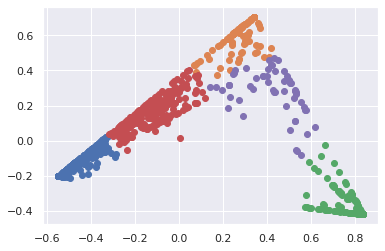

In [ ]:
plt.scatter(train_vecs_pca[y_vecs_kmeans==0,0],train_vecs_pca[y_vecs_kmeans==0,1])
plt.scatter(train_vecs_pca[y_vecs_kmeans==1,0],train_vecs_pca[y_vecs_kmeans==1,1])
plt.scatter(train_vecs_pca[y_vecs_kmeans==2,0],train_vecs_pca[y_vecs_kmeans==2,1])
plt.scatter(train_vecs_pca[y_vecs_kmeans==3,0],train_vecs_pca[y_vecs_kmeans==3,1])
plt.scatter(train_vecs_pca[y_vecs_kmeans==4,0],train_vecs_pca[y_vecs_kmeans==4,1])

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import seaborn as sns
#sns.set()


In [ ]:
"""

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(train_vecs) for n in n_components]

plt.plot(n_components, [m.bic(train_vecs) for m in models], label='BIC')
plt.plot(n_components, [m.aic(train_vecs) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
"""


"\n\nn_components = np.arange(1, 21)\nmodels = [GaussianMixture(n, covariance_type='full', random_state=0).fit(train_vecs) for n in n_components]\n\nplt.plot(n_components, [m.bic(train_vecs) for m in models], label='BIC')\nplt.plot(n_components, [m.aic(train_vecs) for m in models], label='AIC')\nplt.legend(loc='best')\nplt.xlabel('n_components');\n"

In [ ]:
# the error analysis here is because some books records
# are semantically similar and for hat reason the algorithms extracts different number of clusters 

#modelling 

##ALL models contains the BOW, TF-IDF, and Word2Vec transformation

# **k-means**

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.decomposition import PCA


##**k-means BOW , TF**

In [ ]:
def data_bow(data):
  count_vect = CountVectorizer()
  bow = count_vect.fit_transform(data['Records'].values).toarray()
  return bow

def data_tf(data):
  tfidf_vect = TfidfVectorizer()
  tfidf = tfidf_vect.fit_transform(data['Records'].values).toarray()
  return tfidf

def pca_function(data):
  pca = PCA(n_components=2)
  pca=pca.fit_transform(data)  
  return pca


def kmeans(data):
  kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=100)
  pred_y = kmeans.fit_predict(data)
  return pred_y
 

## **Plotting elbow and silhouette for k-means**








In [ ]:
def plot_eblow_silh(data,title_1,title_2):
  wcss = []
  for i in range(2, 6):
      kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
      x = kmeans.fit(data)
      wcss.append(kmeans.inertia_)
  s = []
  for i in range(2, 6):
      kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
      y = kmeans.fit(data)
      s.append(silhouette_score(data, kmeans.labels_))
  #ploting 
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
  axes[0].plot(range(2, 6), wcss)
  axes[1].plot(range(2, 6), s)
  axes[0].set_title(title_1, fontsize=18)
  axes[1].set_title(title_2, fontsize=18)
  return fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

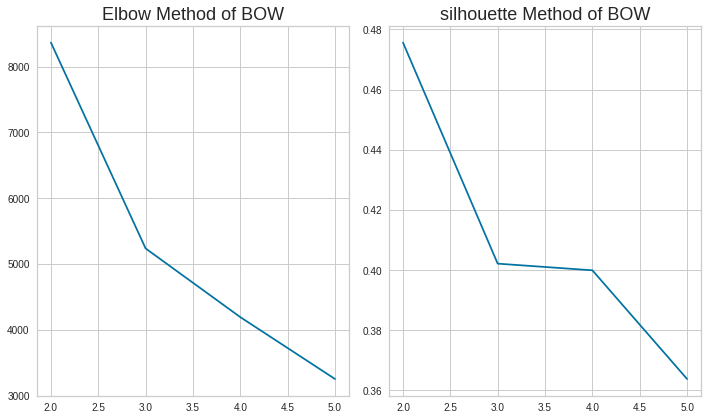

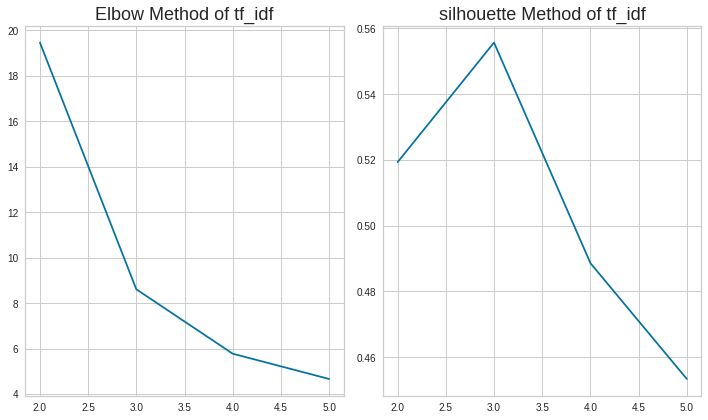

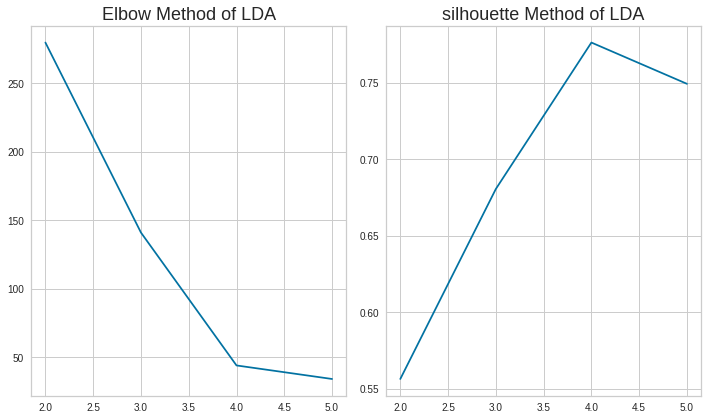

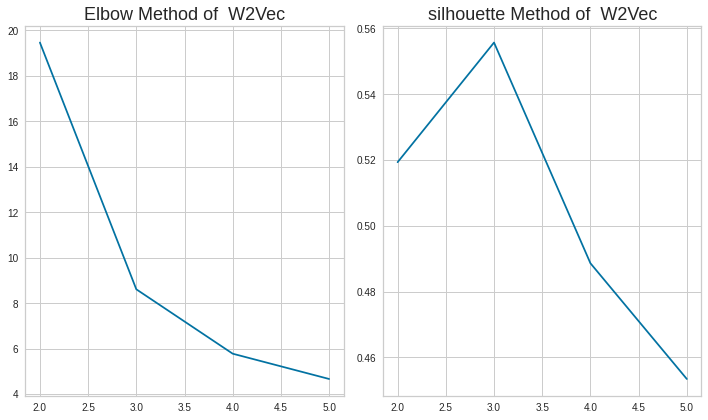

In [ ]:
data_1 = data_bow(data)
x_bow_pca = pca_function(data_1)

data_2 = data_tf(data)
x_tf_pca = pca_function(data_2)

CountVectorizedData_PCA = pca_function(data_2)

# train_vecs = pca_function(train_vecs)
plot_eblow_silh(x_bow_pca,title_1='Elbow Method of BOW',title_2='silhouette Method of BOW')
plot_eblow_silh(x_tf_pca,title_1='Elbow Method of tf_idf',title_2='silhouette Method of tf_idf')
plot_eblow_silh(train_vecs,title_1='Elbow Method of LDA',title_2='silhouette Method of LDA')
plot_eblow_silh(CountVectorizedData_PCA,title_1='Elbow Method of  W2Vec',title_2='silhouette Method of  W2Vec')



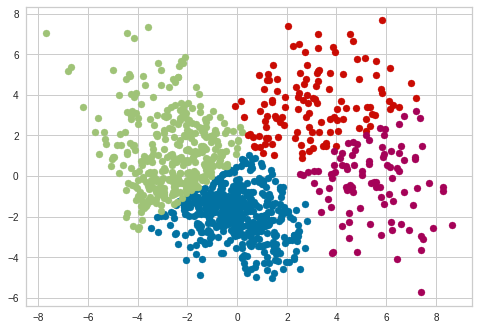

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=1, random_state=0)
y_kmeans_bow = kmeans.fit_predict(x_bow_pca)

kmeans.fit(x_bow_pca)
y_kmeans = kmeans.predict(x_bow_pca)

plt.scatter(x_bow_pca[y_kmeans==0,0],x_bow_pca[y_kmeans==0,1])
plt.scatter(x_bow_pca[y_kmeans==1,0],x_bow_pca[y_kmeans==1,1])
plt.scatter(x_bow_pca[y_kmeans==2,0],x_bow_pca[y_kmeans==2,1])
plt.scatter(x_bow_pca[y_kmeans==3,0],x_bow_pca[y_kmeans==3,1])


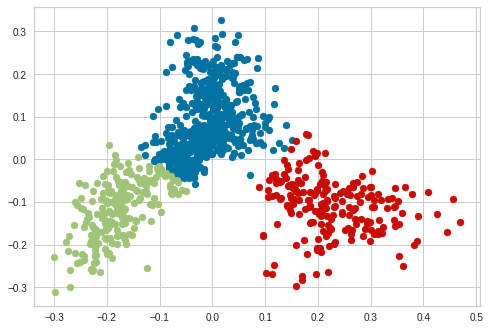

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=1, random_state=0)
y_kmeans_tf = kmeans.fit_predict(x_tf_pca)

kmeans.fit(x_tf_pca)
y_kmeans = kmeans.predict(x_tf_pca)

plt.scatter(x_tf_pca[y_kmeans==0,0],x_tf_pca[y_kmeans==0,1])
plt.scatter(x_tf_pca[y_kmeans==1,0],x_tf_pca[y_kmeans==1,1])
plt.scatter(x_tf_pca[y_kmeans==2,0],x_tf_pca[y_kmeans==2,1])


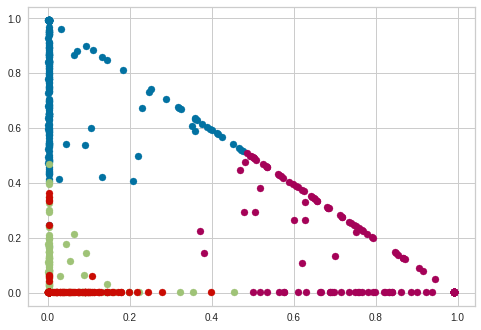

In [ ]:
train_vecs_2 = np.array(train_vecs)

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=1, random_state=0)
y_kmeans_LDA = kmeans.fit_predict(train_vecs_2)

kmeans.fit(train_vecs_2)
y_kmeans_LDA = kmeans.predict(train_vecs_2)

plt.scatter(train_vecs_2[y_kmeans_LDA==0,0],train_vecs_2[y_kmeans_LDA==0,1])
plt.scatter(train_vecs_2[y_kmeans_LDA==1,0],train_vecs_2[y_kmeans_LDA==1,1])
plt.scatter(train_vecs_2[y_kmeans_LDA==2,0],train_vecs_2[y_kmeans_LDA==2,1])
plt.scatter(train_vecs_2[y_kmeans_LDA==3,0],train_vecs_2[y_kmeans_LDA==3,1])


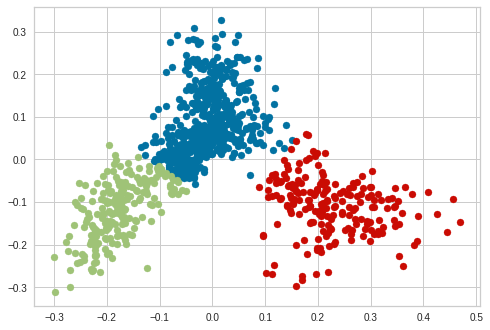

In [ ]:

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=1, random_state=0)
y_kmeans_W2VEC = kmeans.fit_predict(CountVectorizedData_PCA)

kmeans.fit(CountVectorizedData_PCA)
y_kmeans_W2VEC = kmeans.predict(CountVectorizedData_PCA)

plt.scatter(CountVectorizedData_PCA[y_kmeans_W2VEC==0,0],CountVectorizedData_PCA[y_kmeans_W2VEC==0,1])
plt.scatter(CountVectorizedData_PCA[y_kmeans_W2VEC==1,0],CountVectorizedData_PCA[y_kmeans_W2VEC==1,1])
plt.scatter(CountVectorizedData_PCA[y_kmeans_W2VEC==2,0],CountVectorizedData_PCA[y_kmeans_W2VEC==2,1])


##The Evaluation of k-means

###evaluation Silhouette

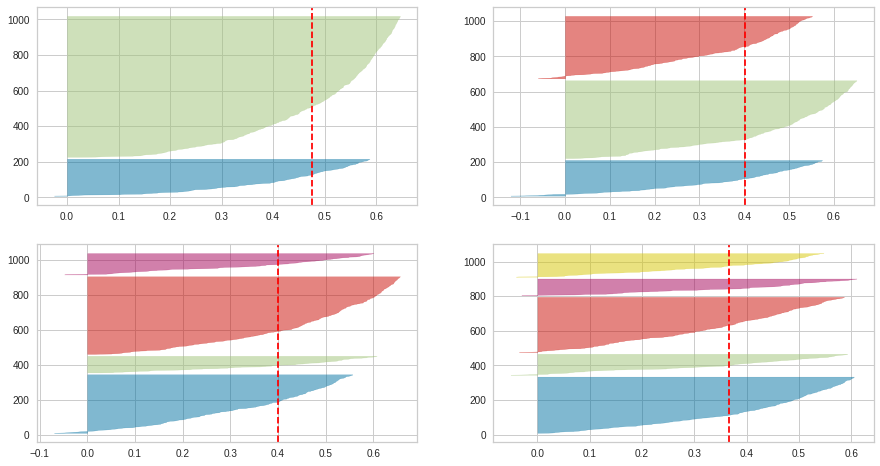

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x_bow_pca)


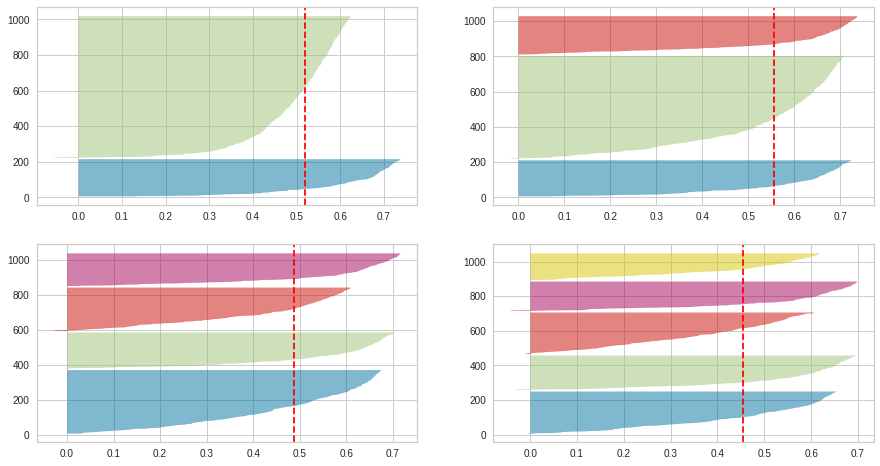

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x_tf_pca)

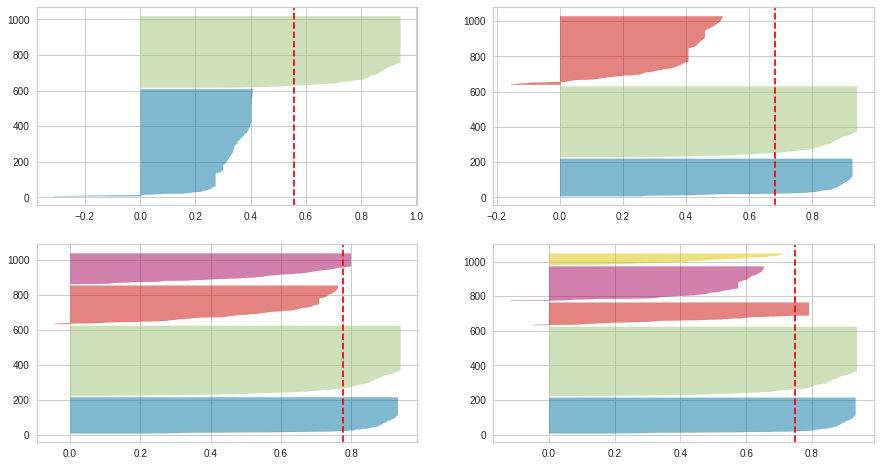

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(train_vecs_2)

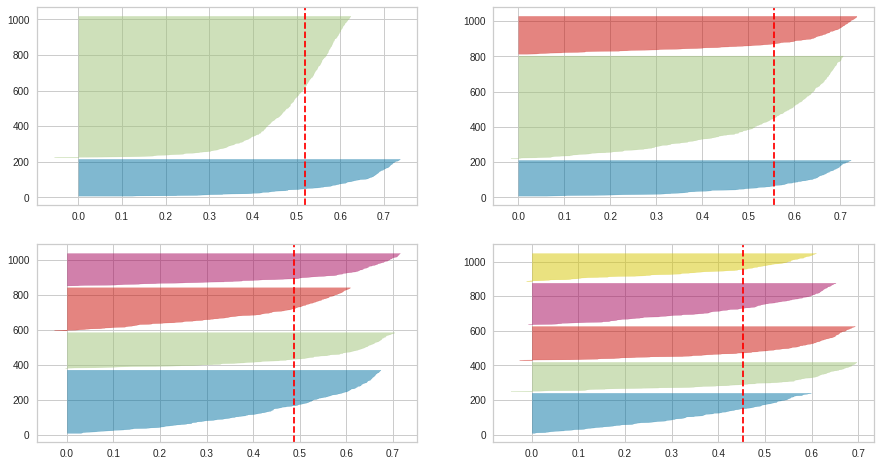

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(CountVectorizedData_PCA)

In [ ]:
# Silhouette analysis of BOW
range_n_clusters = [2,3,4,5]
for num_clusters in range_n_clusters:
  d1 = data_bow(data)
  kmeans_bow = KMeans(n_clusters =num_clusters,random_state=0)
  kmeans_bow.fit(d1)
  labels_bow_3 = kmeans_bow.labels_
  cluster_center_bow=kmeans_bow.cluster_centers_
  # silhouette score
  silhouette_score_bow = metrics.silhouette_score(d1, labels_bow_3, metric='euclidean')
  
  print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_score_bow))

For n_clusters=2, the silhouette score is 0.0891227518738396
For n_clusters=3, the silhouette score is 0.029854527641541166
For n_clusters=4, the silhouette score is 0.034988073666096686
For n_clusters=5, the silhouette score is 0.03976397233577265


In [ ]:
# Silhouette analysis of TF-IDF
range_n_clusters = [2,3,4,5]
for num_clusters in range_n_clusters:
  d2 = data_tf(data)
  kmeans_tf = KMeans(n_clusters =num_clusters,random_state=0)
  kmeans_tf.fit(d2)
  labels_tf_3 = kmeans_tf.labels_
  cluster_center_tf=kmeans_tf.cluster_centers_
  # silhouette score
  silhouette_score_tf = metrics.silhouette_score(d2, labels_tf_3, metric='euclidean')
  
  print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_score_tf))


For n_clusters=2, the silhouette score is 0.013438111648607878
For n_clusters=3, the silhouette score is 0.01699540064775944
For n_clusters=4, the silhouette score is 0.020873988050101818
For n_clusters=5, the silhouette score is 0.022656280985044342


In [ ]:

# Silhouette analysis of LDA

range_n_clusters = [2,3,4,5]
for num_clusters in range_n_clusters:
  kmeans_lda = KMeans(n_clusters =num_clusters,random_state=0)
  kmeans_lda.fit(train_vecs)
  labels_lda_3 = kmeans_lda.labels_
  cluster_center_lda=kmeans_lda.cluster_centers_
  # silhouette score
  silhouette_score_lda = metrics.silhouette_score(train_vecs, labels_lda_3, metric='euclidean')
  
  print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_score_lda))

For n_clusters=2, the silhouette score is 0.5565484762191772
For n_clusters=3, the silhouette score is 0.6806190013885498
For n_clusters=4, the silhouette score is 0.7762296199798584
For n_clusters=5, the silhouette score is 0.7492744326591492


In [ ]:
# Silhouette analysis of W2VEC
range_n_clusters = [2,3,4,5]
for num_clusters in range_n_clusters:
  kmeans_W2VEC = KMeans(n_clusters =num_clusters,random_state=0)
  kmeans_W2VEC.fit(CountVectorizedData_PCA)
  labels_W2VEC_3 = kmeans_W2VEC.labels_
  cluster_center_W2VEC=kmeans_W2VEC.cluster_centers_
  # silhouette score
  silhouette_score_W2VEC = metrics.silhouette_score(CountVectorizedData_PCA, labels_W2VEC_3, metric='euclidean')
  
  print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_score_W2VEC))

For n_clusters=2, the silhouette score is 0.5193042678744014
For n_clusters=3, the silhouette score is 0.5556448259697905
For n_clusters=4, the silhouette score is 0.48861024097674555
For n_clusters=5, the silhouette score is 0.4534555501785177


###evaluation Cohen's Kappa

In [ ]:
#calculate Cohen's Kappa of BOW
from sklearn.metrics import cohen_kappa_score
#define array of ratings for both raters
rater1 = y
rater2 = y_kmeans_bow

#calculate Cohen's Kappa
cohen_kappa_score(rater1, rater2)


-0.08000000000000007

In [ ]:
#calculate Cohen's Kappa of TF-IDF
from sklearn.metrics import cohen_kappa_score
#define array of ratings for both raters
rater1 = y
rater3 = y_kmeans_tf

#calculate Cohen's Kappa
cohen_kappa_score(rater1, rater3)

-0.007500000000000062

In [ ]:
#calculate Cohen's Kappa of LDA
from sklearn.metrics import cohen_kappa_score
#define array of ratings for both raters
rater1 = y
rater4 = y_kmeans_LDA

#calculate Cohen's Kappa
cohen_kappa_score(rater1, rater4)


0.0012499999999999734

In [ ]:
#calculate Cohen's Kappa of BOW
from sklearn.metrics import cohen_kappa_score
#define array of ratings for both raters
rater1 = y
rater5 = y_kmeans_W2VEC

#calculate Cohen's Kappa
cohen_kappa_score(rater1, rater5)

-0.007500000000000062

## **Check quality of weak classification by the model for BOW and TF-IDF**

In [ ]:
print('Accuracy score: {0:0.2f}'. format(correct_labels_bow_3/float(y.size)))


Accuracy score: 0.51


In [ ]:
# check how many of the samples were correctly labeled
correct_labels_tf_3 = sum(y == labels_tf_3)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels_tf_3, y.size))

Result: 607 out of 1000 samples were correctly labeled.


In [ ]:
print('Accuracy score: {0:0.2f}'. format(correct_labels_tf_3/float(y.size)))


Accuracy score: 0.61


## **K-Means model with different clusters**

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
d5 = data_bow(data)
kmeans.fit(d5)

# check how many of the samples were correctly labeled
labels_bow_5 = kmeans.labels_

correct_labels_bow_5 = sum(y == labels_bow_5)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_bow_5, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_bow_5/float(y.size)))

Result: 509 out of 1000 samples were correctly labeled.
Accuracy score: 0.51


In [ ]:
d5 = data_tf(data)
kmeans_tf = KMeans(n_clusters =5,random_state=0)
kmeans_tf.fit(d5)
labels_tf_5 = kmeans_tf.labels_
cluster_center_tf_5=kmeans_tf.cluster_centers_
correct_labels_tf_5 = sum(y == labels_tf_5)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_tf_5, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_tf_5/float(y.size)))

Result: 607 out of 1000 samples were correctly labeled.
Accuracy score: 0.61


In [ ]:
kmeans_lda = KMeans(n_clusters =5,random_state=0)
kmeans_lda.fit(train_vecs)
labels_lda_4 = kmeans_lda.labels_
cluster_center_lda=kmeans_lda.cluster_centers_


correct_labels_lda_4 = sum(y == labels_lda_4)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_lda_4, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_lda_4/float(y.size)))

Result: 201 out of 1000 samples were correctly labeled.
Accuracy score: 0.20


In [ ]:
kmeans_W2VEC = KMeans(n_clusters =5,random_state=0)
kmeans_W2VEC.fit(CountVectorizedData)
labels_W2VEC_3 = kmeans_W2VEC.labels_
cluster_center_W2VEC=kmeans_W2VEC.cluster_centers_

correct_labels_W2VEC_5 = sum(y == labels_W2VEC_3)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_W2VEC_5, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_W2VEC_5/float(y.size)))

Result: 260 out of 1000 samples were correctly labeled.
Accuracy score: 0.26


In [ ]:
----------------------------------

#EM algorithm

In [ ]:
main_DF=pd.read_csv("mustafa_data.csv")
main_DF

,Unnamed: 0,Records,Labels
0,0,emma by jane austen volum i chapter i emma woo...,austen-emma
1,1,her temper had hard allow her impos ani restra...,austen-emma
2,2,father herself were left dine togeth with no p...,austen-emma
3,3,of last seven year equal foot perfect unreserv...,austen-emma
4,4,meet her in convers ration or play the evil of...,austen-emma
...,...,...,...
995,995,of switzerland i mark long winter isol i see c...,whitman-leaves
996,996,in aleppo i see picturesqu crowd at fair of kh...,whitman-leaves
997,997,i see result of persever industri of my race i...,whitman-leaves
998,998,mountain live lawless on taurus or caucasus yo...,whitman-leaves


In [ ]:
target_names = main_DF['Labels'].unique()
print(target_names)


['austen-emma' 'bible-kjv' 'chesterton-brown' 'edgeworth-parents'
 'whitman-leaves']


In [ ]:
#encoding labels

main_DF['Labels']=main_DF['Labels'].map({'austen-emma':1,
                             'bible-kjv':2,
                             'edgeworth-parents':3,
                             'chesterton-brown':4,
                             'whitman-leaves':5})
main_DF

,Unnamed: 0,Records,Labels
0,0,emma by jane austen volum i chapter i emma woo...,1
1,1,her temper had hard allow her impos ani restra...,1
2,2,father herself were left dine togeth with no p...,1
3,3,of last seven year equal foot perfect unreserv...,1
4,4,meet her in convers ration or play the evil of...,1
...,...,...,...
995,995,of switzerland i mark long winter isol i see c...,5
996,996,in aleppo i see picturesqu crowd at fair of kh...,5
997,997,i see result of persever industri of my race i...,5
998,998,mountain live lawless on taurus or caucasus yo...,5


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

def get_silhouette_score(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

def get_gmm_score(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50)
    gmm.fit(X)
    gmm_scores = gmm.score_samples(X)
    score = np.exp(gmm_scores).sum()
    return score

def get_scores(X, k):
    return k, get_silhouette_score(X, k), get_gmm_score(X, k)

##with BOW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(main_DF['Records'])
X.shape

(1000, 8429)

###silhouette_with_Number_without_PCA

In [ ]:
n_components = np.arange(2, 7)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X.toarray()) for n in n_components]

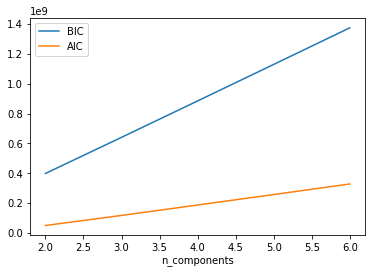

In [ ]:

plt.plot(n_components, [m.bic(np.asarray(X.todense())) for m in models], label='BIC')
plt.plot(n_components, [m.aic(np.asarray(X.todense())) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');


For n_clusters = 2 The average silhouette_score is : 0.10960954420179396


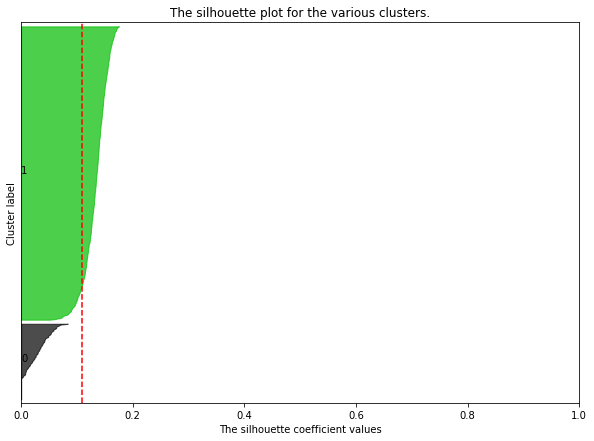

For n_clusters = 3 The average silhouette_score is : 0.029571574361867307


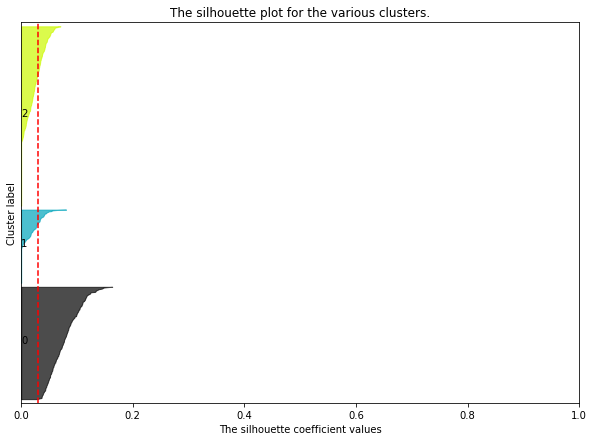

For n_clusters = 4 The average silhouette_score is : 0.033334364661473215


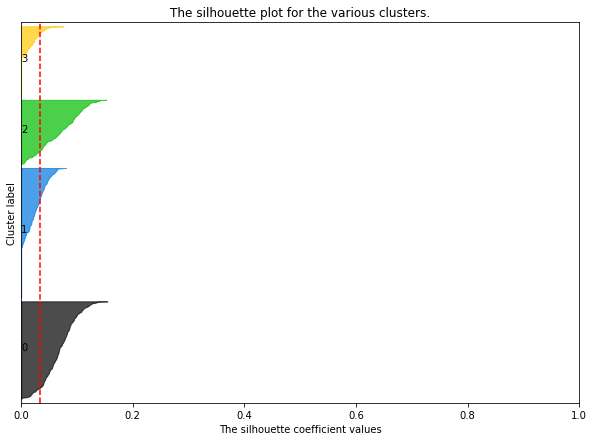

For n_clusters = 5 The average silhouette_score is : 0.03822313564257699


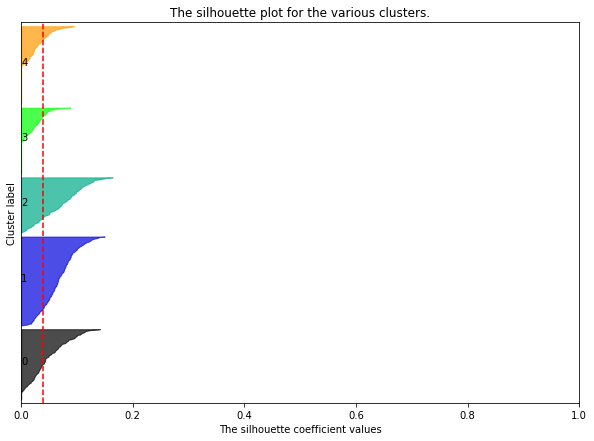

For n_clusters = 6 The average silhouette_score is : 0.03862902586203087


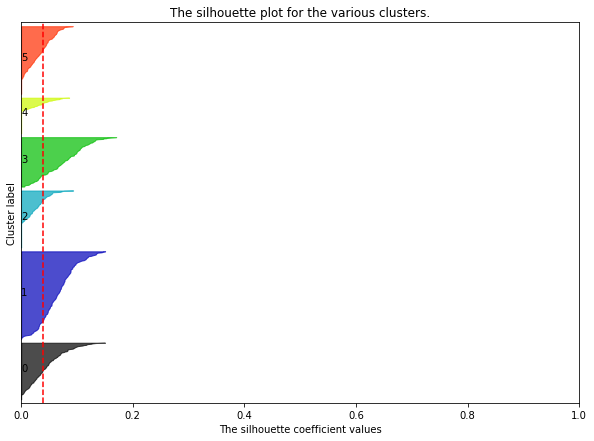

For n_clusters = 7 The average silhouette_score is : 0.031112560524585213


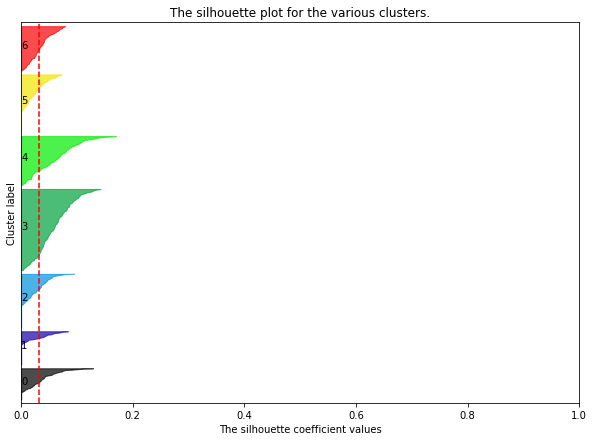

In [ ]:

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

silhouette_with_Number_without_PCA={}

range_n_clusters = [2, 3, 4, 5, 6,7]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(10, 7)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full')
    clusterer.fit(X.toarray())
    cluster_labels=clusterer.predict(X.toarray())
    cluster_labels.shape
    silhouette_avg = silhouette_score(X.toarray(), cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_with_Number_without_PCA[n_clusters]=silhouette_avg
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(0, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()
    

In [ ]:
silhouette_with_Number_without_PCA

{2: 0.10960954420179396,
 3: 0.029571574361867307,
 4: 0.033334364661473215,
 5: 0.03822313564257699,
 6: 0.03862902586203087,
 7: 0.031112560524585213}

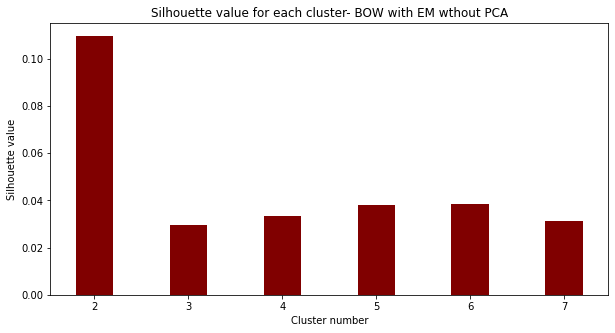

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
data =  {2:0.10960954420179396, 3:0.029571574361867307,4:0.033334364661473215, 5:0.03822313564257699, 6:0.03862902586203087,7:0.031112560524585213}

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Cluster number")
plt.ylabel("Silhouette value")
plt.title("Silhouette value for each cluster- BOW with EM wthout PCA")
plt.show()

C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp

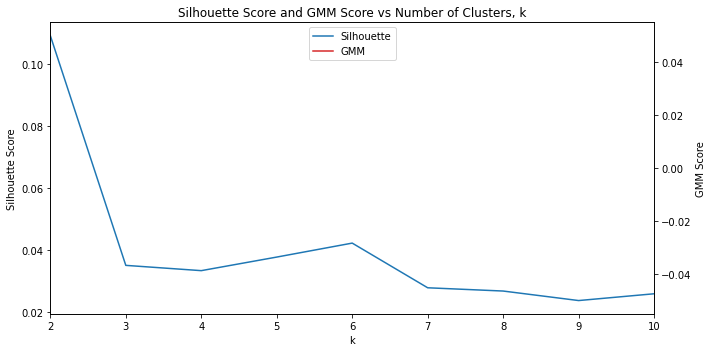

In [ ]:
score_df = pd.DataFrame([get_scores(X.toarray(), k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])
fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])

line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()

###BOW with PCA with 1000 feature

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np
svd = TruncatedSVD(n_components=1000, random_state=42)
svd=svd.fit_transform(X)



In [ ]:

principalDf = pd.DataFrame(data =svd)
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,13.086090,-1.704323,-3.991909,-7.862559,1.539090,2.612264,-0.499399,-1.339353,0.186486,-0.114787,...,-0.109503,0.031510,0.056013,-0.063214,0.283495,0.030628,0.023758,-0.035991,-0.055792,0.059187
1,9.812937,-3.601041,-1.376873,-5.284543,3.011010,0.480283,-1.230472,-0.123060,-0.284951,1.058380,...,0.055853,0.031784,-0.102761,-0.069031,-0.098297,-0.059936,0.028531,-0.024051,-0.003412,0.008913
2,11.730729,-3.921148,-0.855381,-7.916918,6.197712,2.377884,0.261939,-2.964991,1.191430,0.746630,...,-0.126201,-0.096243,-0.027850,0.010929,0.014326,-0.074912,-0.170240,0.119713,-0.128112,-0.084477
3,10.706347,-4.596704,2.804748,-5.696036,4.891641,-0.576155,0.910335,1.691414,2.078827,-1.545529,...,-0.052400,0.081279,0.414755,0.068182,0.043835,-0.210196,-0.032277,0.060434,-0.088352,-0.002968
4,9.755221,-2.150959,1.623988,-3.762534,1.343660,-2.248726,1.252520,0.968628,-3.313291,-1.066755,...,-0.057925,0.041754,-0.061873,-0.103298,-0.010401,-0.021746,-0.011873,-0.047682,-0.007090,0.007305


In [ ]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(2,15)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(svd) for n in n_components]


Text(0.5, 0, 'n_components')

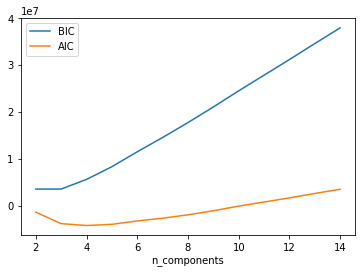

In [ ]:
from matplotlib import pyplot as plt

plt.plot(n_components, [m.bic(svd) for m in models], label='BIC')
plt.plot(n_components, [m.aic(svd) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [ ]:

gmm = GaussianMixture(n_components=3)
gmm.fit(svd)

labels = gmm.predict(svd)


In [ ]:

predictions=gmm.predict_proba(svd)
predictions

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.10907551478763367


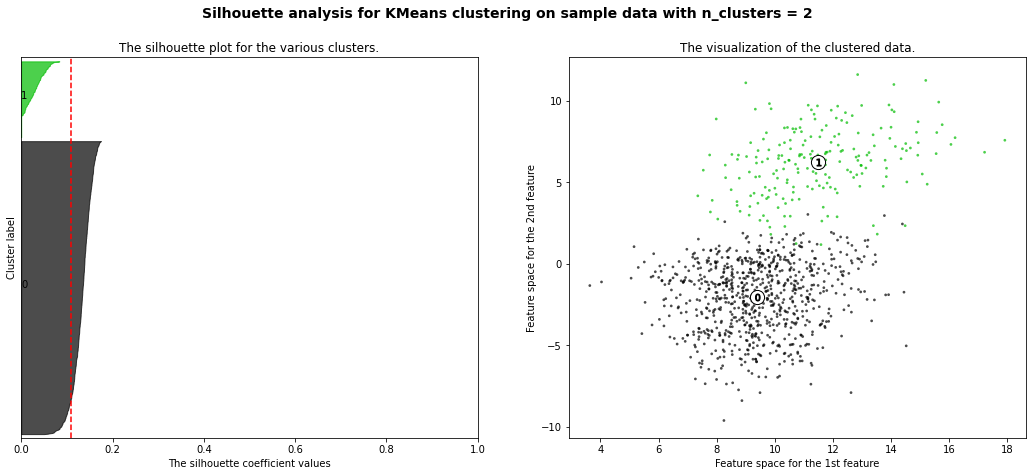

For n_clusters = 3 The average silhouette_score is : 0.03649574765949201


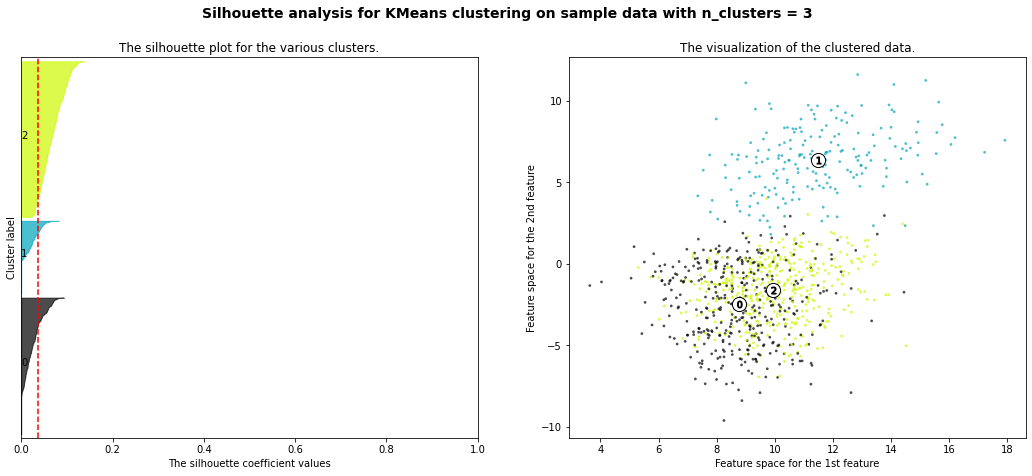

For n_clusters = 4 The average silhouette_score is : 0.031855242466939306


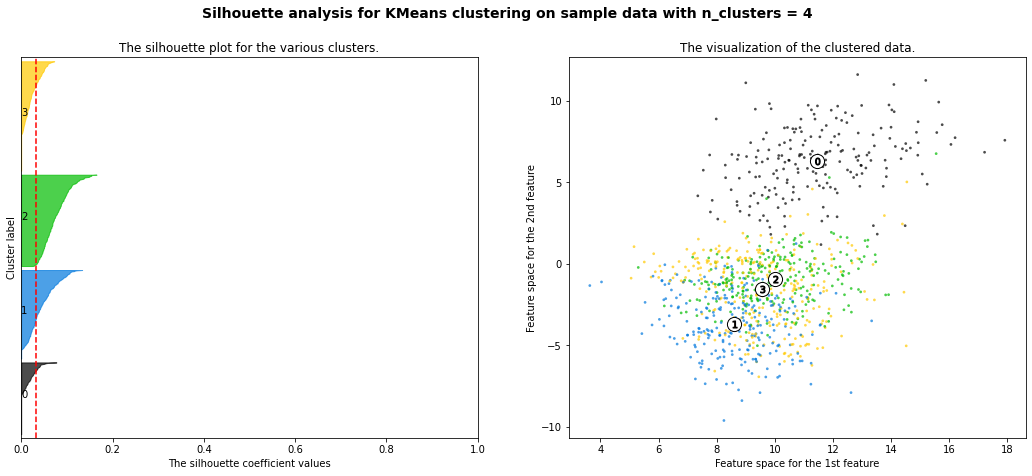

For n_clusters = 5 The average silhouette_score is : 0.03258753543058186


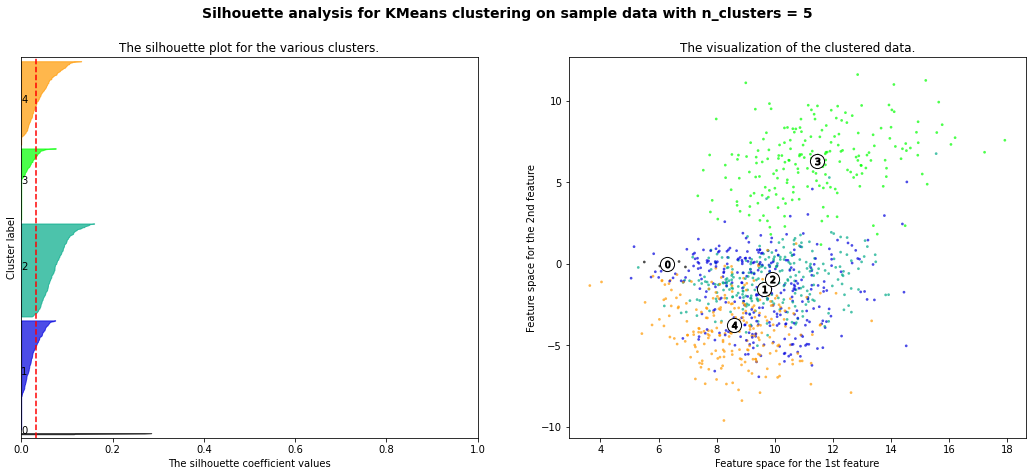

For n_clusters = 6 The average silhouette_score is : 0.04188012279742387


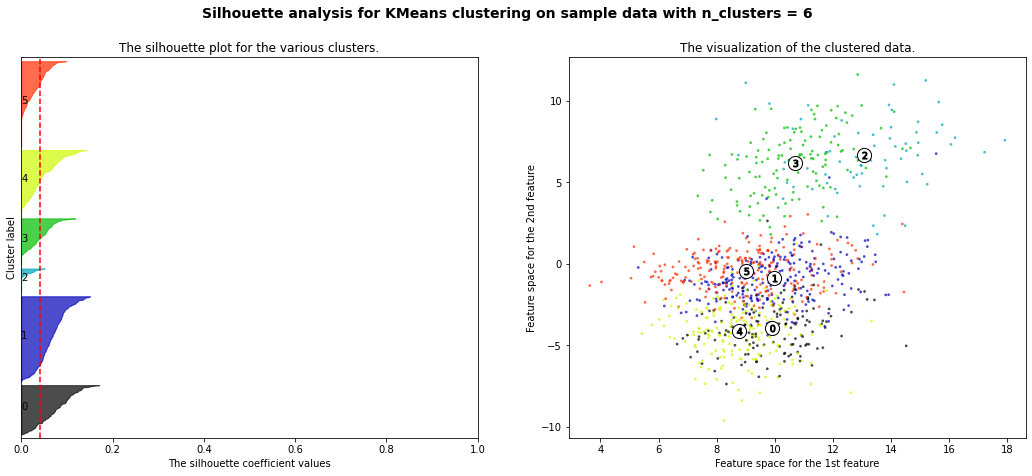

For n_clusters = 7 The average silhouette_score is : 0.028259186825733196


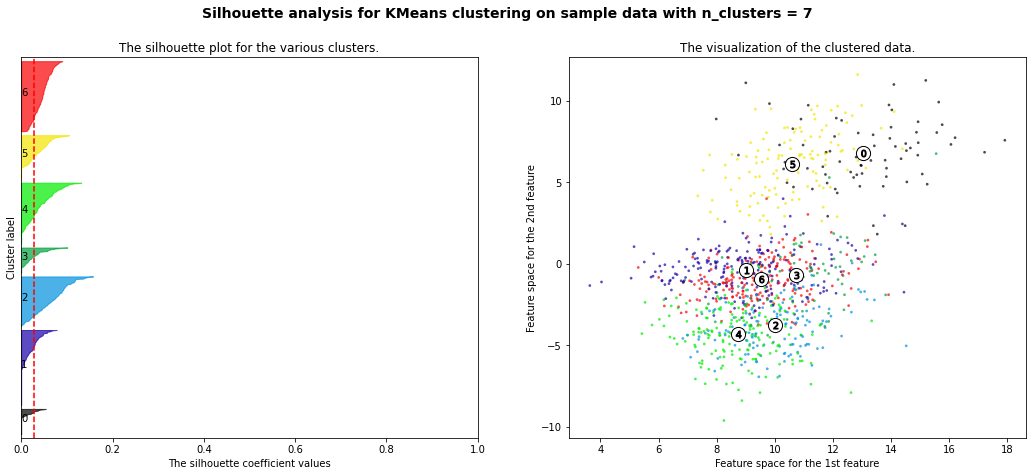

In [ ]:
silhouette_with_Number_PCA_1000={}

range_n_clusters = [2, 3, 4, 5, 6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, len(svd) + (n_clusters + 1) * 10])
    clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full')
    clusterer.fit(svd)
    cluster_labels=clusterer.predict(svd)
    cluster_labels.shape
    silhouette_avg = silhouette_score(svd, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_with_Number_PCA_1000[n_clusters]=silhouette_avg
    sample_silhouette_values = silhouette_samples(svd, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(0, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(svd[:, 0], svd[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [ ]:
silhouette_with_Number_PCA_1000

{2: 0.10907551478763367,
 3: 0.03649574765949201,
 4: 0.031855242466939306,
 5: 0.03258753543058186,
 6: 0.04188012279742387,
 7: 0.028259186825733196}

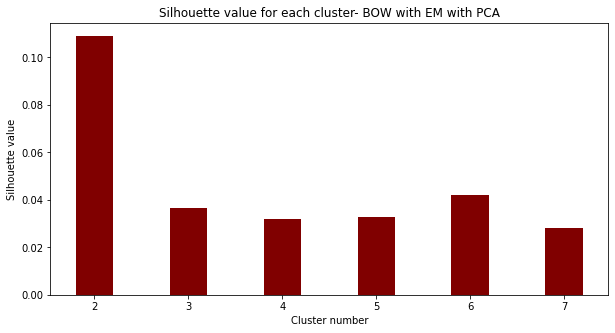

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
data = {2: 0.10907551478763367,
 3: 0.03649574765949201,
 4: 0.031855242466939306,
 5: 0.03258753543058186,
 6: 0.04188012279742387,
 7: 0.028259186825733196}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Cluster number")
plt.ylabel("Silhouette value")
plt.title("Silhouette value for each cluster- BOW with EM with PCA")
plt.show()

C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_21860/408859964.py:16: RuntimeWarning: overflow encountered in exp

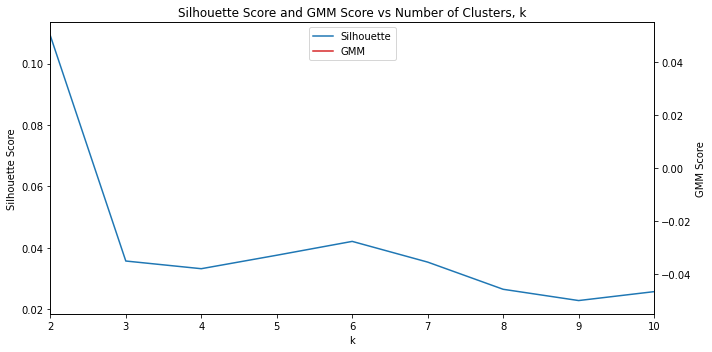

In [ ]:
score_df = pd.DataFrame([get_scores(svd, k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])
fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])

line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()


##EM with N-grams

In [ ]:
x=main_DF['Records'].values
x.shape
# Generating ngrams
matrix_ngram = CountVectorizer(ngram_range=(1,3), max_features=1000, binary=True)

Y=main_DF.iloc[:,0:1]
X_ngram= matrix_ngram.fit_transform(x).toarray()

X_ngram_vector = pd.DataFrame(X_ngram,columns = matrix_ngram.get_feature_names_out() )
matrix_ngram._validate_vocabulary()

In [ ]:
X_ngram

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int64)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.019123697169602813


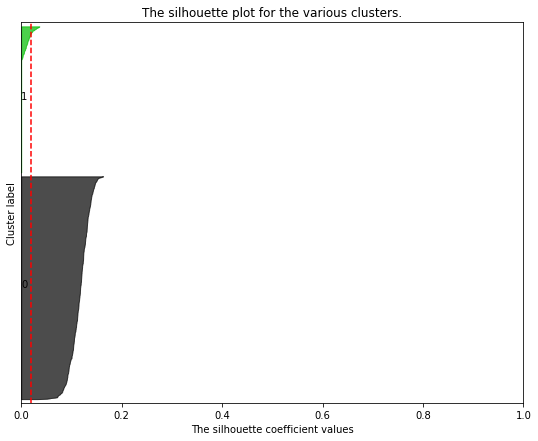

For n_clusters = 3 The average silhouette_score is : 0.022151014456343


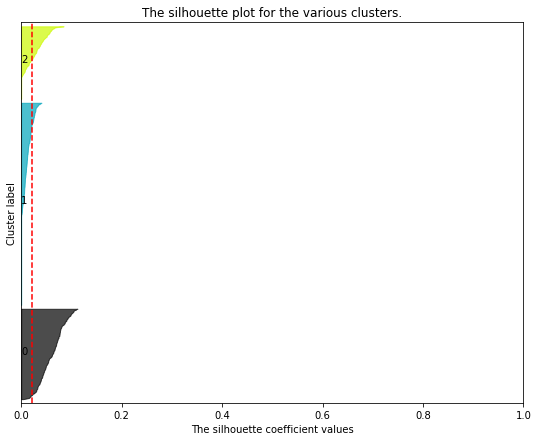

For n_clusters = 4 The average silhouette_score is : 0.010006668127788413


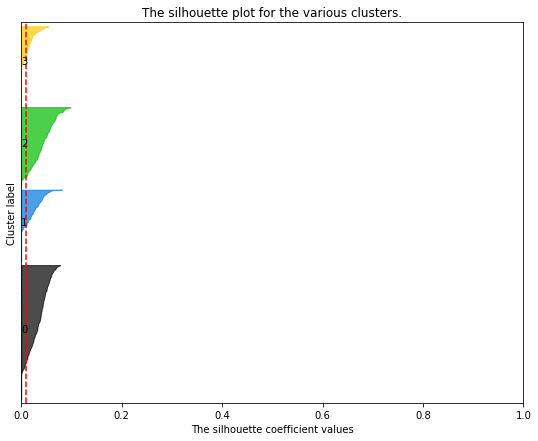

For n_clusters = 5 The average silhouette_score is : 0.009954015375822436


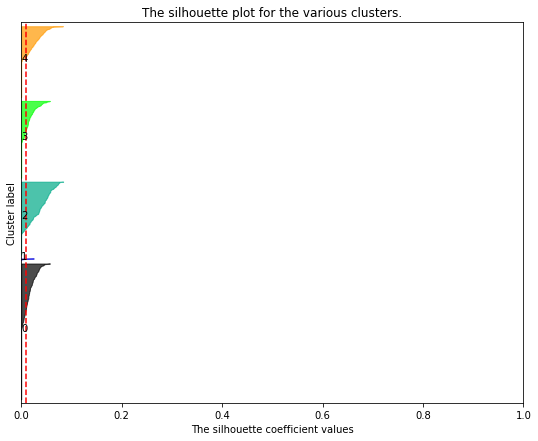

For n_clusters = 6 The average silhouette_score is : 0.0019319952110149145


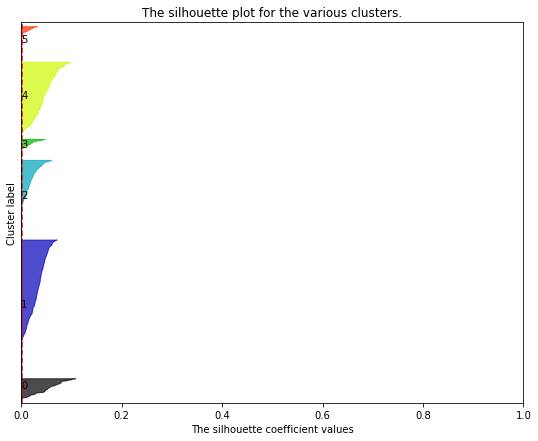

For n_clusters = 7 The average silhouette_score is : -0.004408944227786098


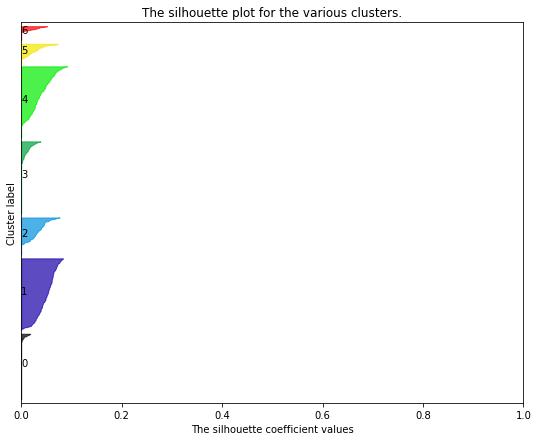

For n_clusters = 8 The average silhouette_score is : -0.0013889086338510256


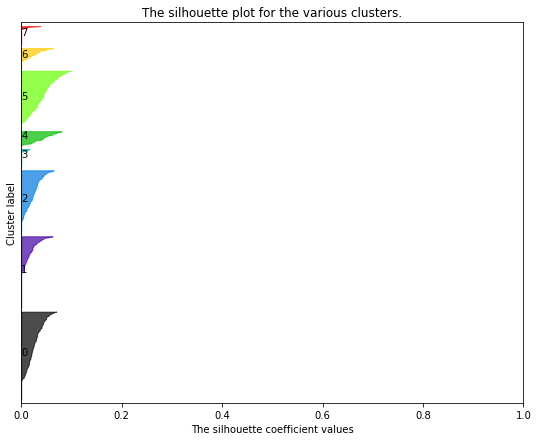

For n_clusters = 9 The average silhouette_score is : -0.0007808903201369368


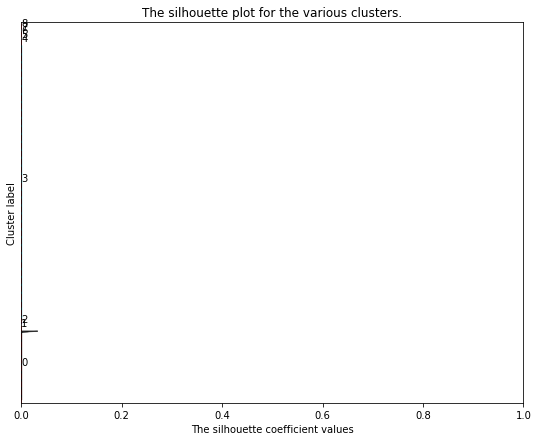

For n_clusters = 10 The average silhouette_score is : 0.005033786377808637


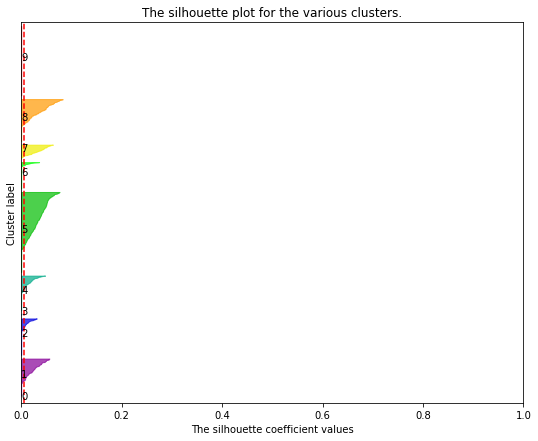

In [ ]:
silhouette_N_gram_without_PCA={}

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(9, 7)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full')
    clusterer.fit(X_ngram)
    cluster_labels=clusterer.predict(X_ngram)
    cluster_labels.shape
    silhouette_avg = silhouette_score(X_ngram, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_N_gram_without_PCA[n_clusters]=silhouette_avg
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(0, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()
    

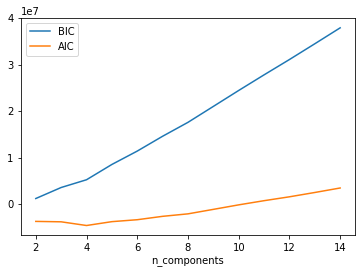

In [ ]:
n_components = np.arange(2,15)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_ngram) for n in n_components]

plt.plot(n_components, [m.bic(X_ngram) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_ngram) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

##EM with TF_IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_tf_idf = vectorizer.fit_transform(main_DF['Records'].values)
vectorizer.get_feature_names_out()


print(X_tf_idf.shape)

(1000, 8429)


###Apply PCA

In [ ]:
svd2 = TruncatedSVD(n_components=1000, random_state=42)
svd2=svd2.fit_transform(X_tf_idf)
principalDf2 = pd.DataFrame(data =svd2)
principalDf2.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.326504,-0.115304,0.194965,-0.036194,-0.147931,0.085562,-0.005245,0.026571,0.036941,0.043514,...,0.010750,-0.004641,0.002514,-0.009804,0.005181,-0.002454,0.003366,0.006059,-0.002780,-0.002836
1,0.325764,-0.159422,0.172431,-0.061605,-0.126338,0.072145,0.003844,-0.025682,0.019338,-0.003036,...,0.000393,0.003691,-0.004948,0.001512,-0.003800,-0.002381,-0.006017,-0.003112,0.004176,0.000488
2,0.361626,-0.162507,0.312863,-0.085648,-0.142051,-0.063154,-0.006702,0.062376,0.030719,-0.003821,...,-0.001326,0.005082,0.000916,-0.006233,0.003182,0.002448,0.001968,-0.004330,-0.009283,-0.001511
3,0.399347,-0.176837,0.277614,-0.059177,-0.094731,0.019052,0.036559,0.017068,-0.007456,-0.026174,...,-0.007208,-0.008707,0.003685,0.001243,-0.000734,-0.002172,-0.004285,-0.007848,-0.005248,-0.001073
4,0.324381,-0.106635,0.137625,0.021574,-0.106990,0.066480,0.002790,-0.020994,-0.024814,0.056622,...,0.000155,0.004956,0.004624,0.000313,-0.002194,0.001363,-0.000833,-0.000840,-0.003864,0.000410


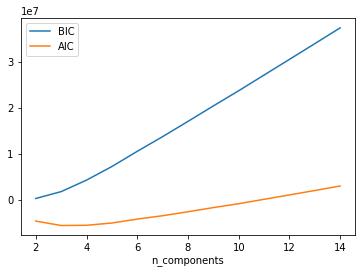

In [ ]:
n_components = np.arange(2,15)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(svd2) for n in n_components]

plt.plot(n_components, [m.bic(svd2) for m in models], label='BIC')
plt.plot(n_components, [m.aic(svd2) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

C:\Users\Nourhan\AppData\Local\Temp/ipykernel_15228/1266560795.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_15228/1266560795.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_15228/1266560795.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_15228/1266560795.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_15228/1266560795.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_15228/1266560795.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_15228/1266560795.py:16: RuntimeWarning: overflow encountered

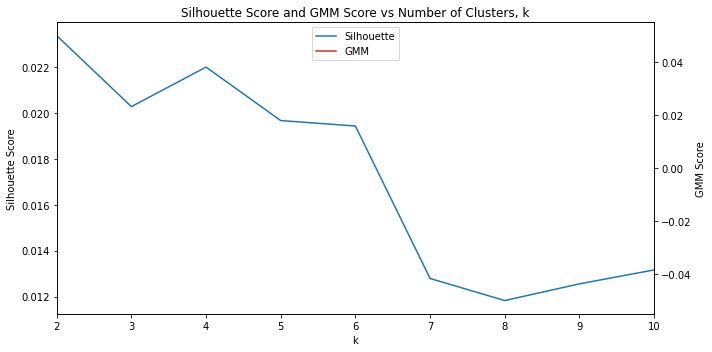

In [ ]:
score_df = pd.DataFrame([get_scores(svd2, k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])
fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])

line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()

##EM with Word2Vec

In [ ]:
pip install  --upgrade gensim --


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
main_DF

,Unnamed: 0,Records,Labels
0,0,emma by jane austen volum i chapter i emma woo...,1
1,1,her temper had hard allow her impos ani restra...,1
2,2,father herself were left dine togeth with no p...,1
3,3,of last seven year equal foot perfect unreserv...,1
4,4,meet her in convers ration or play the evil of...,1
...,...,...,...
995,995,of switzerland i mark long winter isol i see c...,5
996,996,in aleppo i see picturesqu crowd at fair of kh...,5
997,997,i see result of persever industri of my race i...,5
998,998,mountain live lawless on taurus or caucasus yo...,5


In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
corpus = main_DF['Records'].values
vectorizer = CountVectorizer(stop_words='english')

X = vectorizer.fit_transform(corpus)
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

CountVectorizedData.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandon,abas,abash,abat,abbey,abbot,abbrevi,abel,abey,abid,...,zibeon,zillah,zilpah,zimran,ziphion,zoar,zohar,zone,zuyder,zuzim
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pip install --upgrade numpy


  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Nourhan\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\Users\Nourhan\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [ ]:
WordsVocab=CountVectorizedData.columns[:-1] 


In [ ]:
def FunctionText2Vec(inpTextData):
    # Converting the text to numeric data
    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    
    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()
    for i in range(CountVecData.shape[0]):
        Sentence = np.zeros(300)
        for word in WordsVocab[CountVecData.iloc[i,:]]:
            #print(word)
            if word in wv.key_to_index.keys():    
                Sentence=Sentence+wv[word]
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = main_DF["Records"].values
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
print(CountVectorizedData.shape)
CountVectorizedData.head()

(1000, 8219)


c:\Users\Nourhan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandon,abas,abash,abat,abbey,abbot,abbrevi,abel,abey,abid,...,zibeon,zillah,zilpah,zimran,ziphion,zoar,zohar,zone,zuyder,zuzim
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\Nourhan\AppData\Local\Temp/ipykernel_22676/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_22676/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_22676/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_22676/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_22676/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_22676/408859964.py:16: RuntimeWarning: overflow encountered in exp
  score = np.exp(gmm_scores).sum()
C:\Users\Nourhan\AppData\Local\Temp/ipykernel_22676/408859964.py:16: RuntimeWarning: overflow encountered in exp

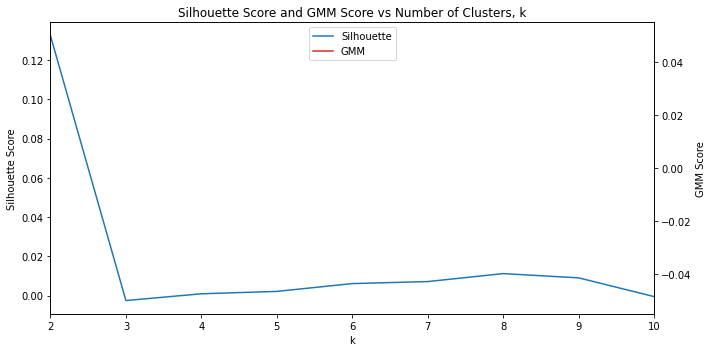

In [ ]:
import numpy as np
score_df = pd.DataFrame([get_scores(CountVectorizedData, k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])
fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])

line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()

##EM with LDA

In [ ]:
train_vecs


NameError: ignored

In [ ]:
n_components = np.arange(2, 7)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(train_vecs) for n in n_components]


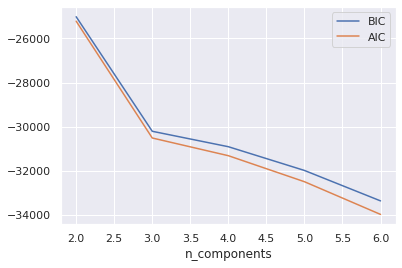

In [ ]:
plt.plot(n_components, [m.bic(np.array(train_vecs)) for m in models], label='BIC')
plt.plot(n_components, [m.aic(np.array(train_vecs)) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

For n_clusters = 2 The average silhouette_score is : 0.39527947


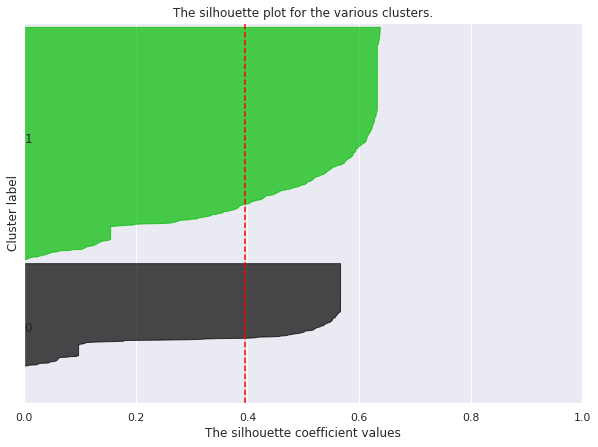

For n_clusters = 3 The average silhouette_score is : 0.38492116


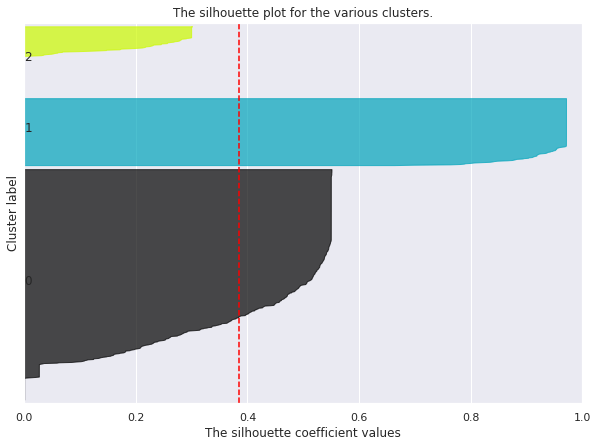

For n_clusters = 4 The average silhouette_score is : 0.24347602


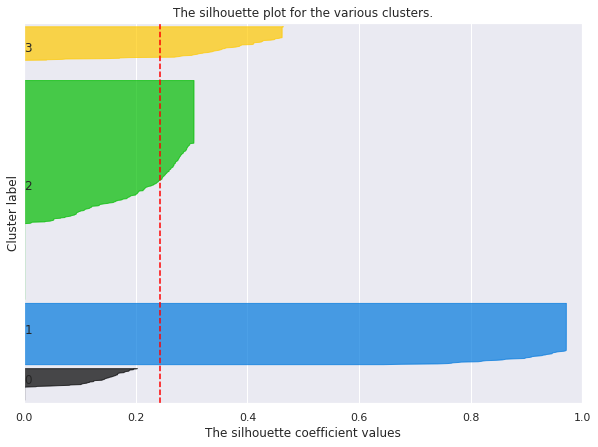

For n_clusters = 5 The average silhouette_score is : 0.15719423


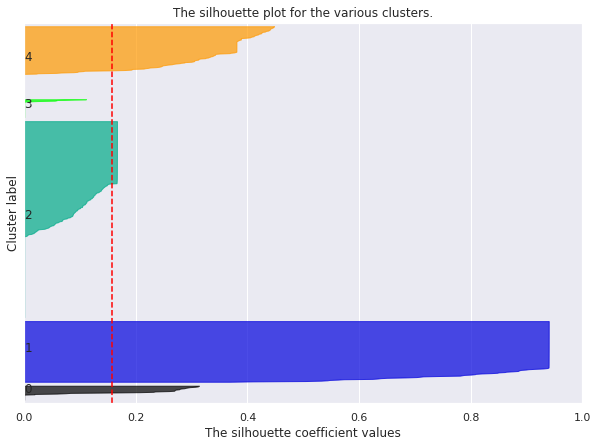

For n_clusters = 6 The average silhouette_score is : 0.16367999


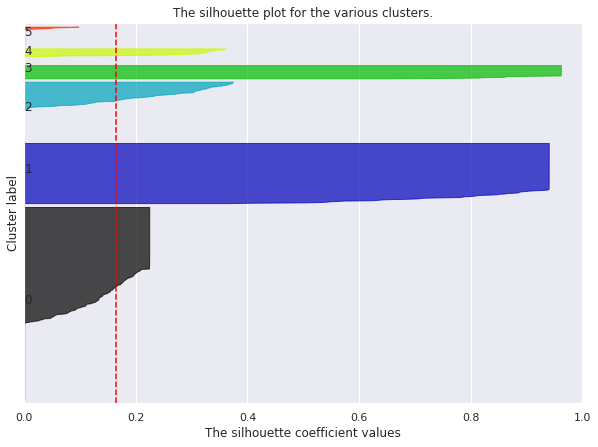

For n_clusters = 7 The average silhouette_score is : 0.30664235


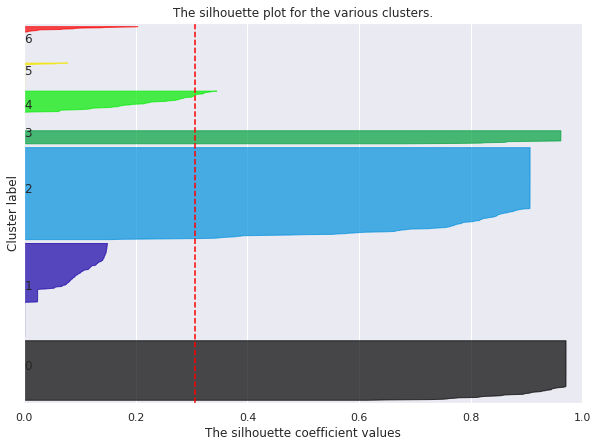

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

silhouette_with_Number_without_PCA_LDA={}

range_n_clusters = [2, 3, 4, 5, 6,7]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(10, 7)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0,np.array( train_vecs).shape[0] + (n_clusters + 1) * 10])
    clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full')
    clusterer.fit(train_vecs)
    cluster_labels=clusterer.predict(train_vecs)
    cluster_labels.shape
    silhouette_avg = silhouette_score(train_vecs, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_with_Number_without_PCA_LDA[n_clusters]=silhouette_avg
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(train_vecs, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(0, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()
    

In [ ]:
silhouette_with_Number_without_PCA_LDA


{2: 0.39527947,
 3: 0.38492116,
 4: 0.24347602,
 5: 0.15719423,
 6: 0.16367999,
 7: 0.30664235}

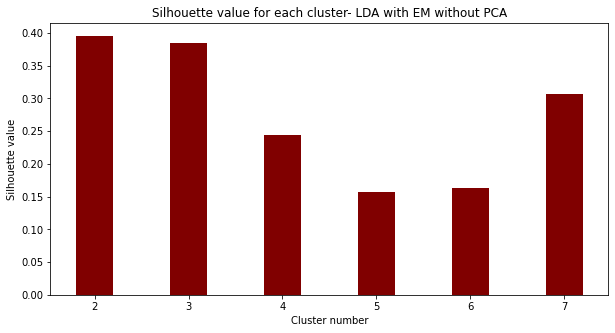

In [ ]:

 
data = {2: 0.39527947,
 3: 0.38492116,
 4: 0.24347602,
 5: 0.15719423,
 6: 0.16367999,
 7: 0.30664235}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Cluster number")
plt.ylabel("Silhouette value")
plt.title("Silhouette value for each cluster- LDA with EM without PCA")
plt.show()

###With PCA

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np
svd4 = TruncatedSVD(n_components=2, random_state=42)
svd4=svd4.fit_transform(train_vecs)

principalDf4 = pd.DataFrame(data =svd4)
principalDf4.columns =['PCA1', 'PCA2']

principalDf4["Labels"]=main_DF['Labels']



principalDf4.head()

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

,PCA1,PCA2,Labels
0,0.975712,-0.041367,austen-emma
1,0.874938,-0.031342,austen-emma
2,0.975775,-0.041401,austen-emma
3,0.975788,-0.041398,austen-emma
4,0.911578,-0.035780,austen-emma


In [ ]:
principalDf4.to_csv("LDA_EM.csv")


For n_clusters = 2 The average silhouette_score is : 0.57233286


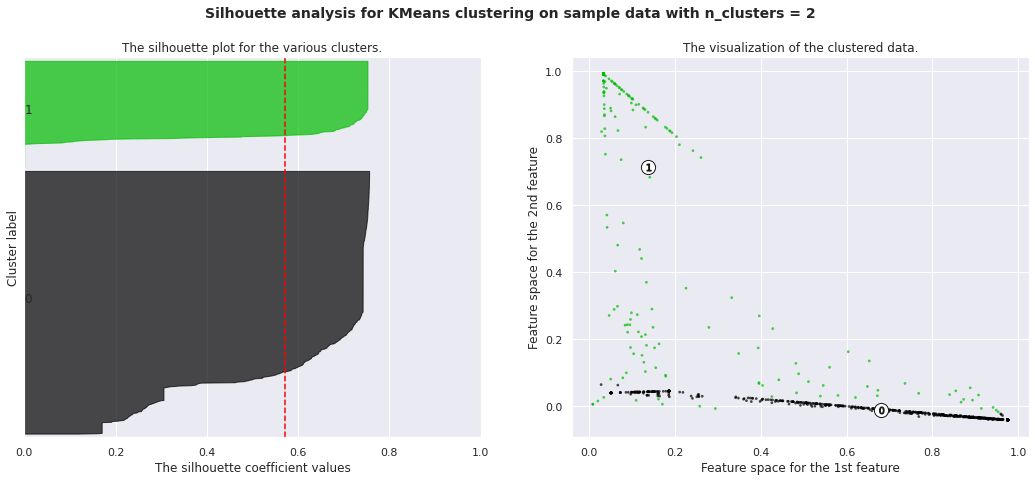

For n_clusters = 3 The average silhouette_score is : 0.5580277


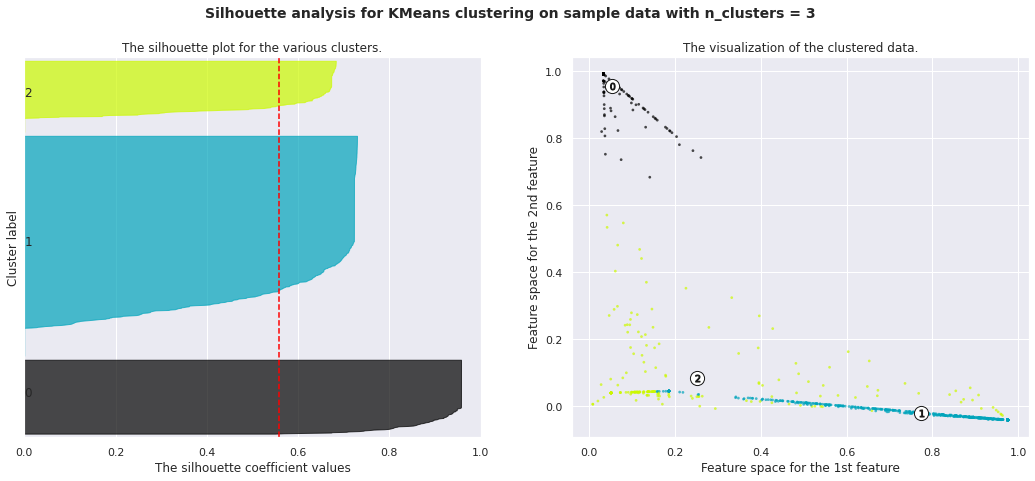

For n_clusters = 4 The average silhouette_score is : 0.51278967


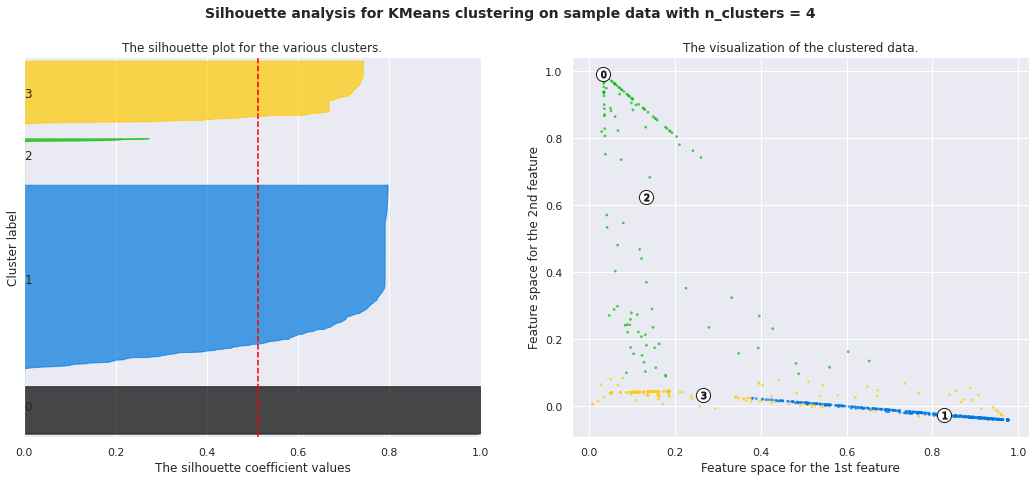

For n_clusters = 5 The average silhouette_score is : 0.36511812


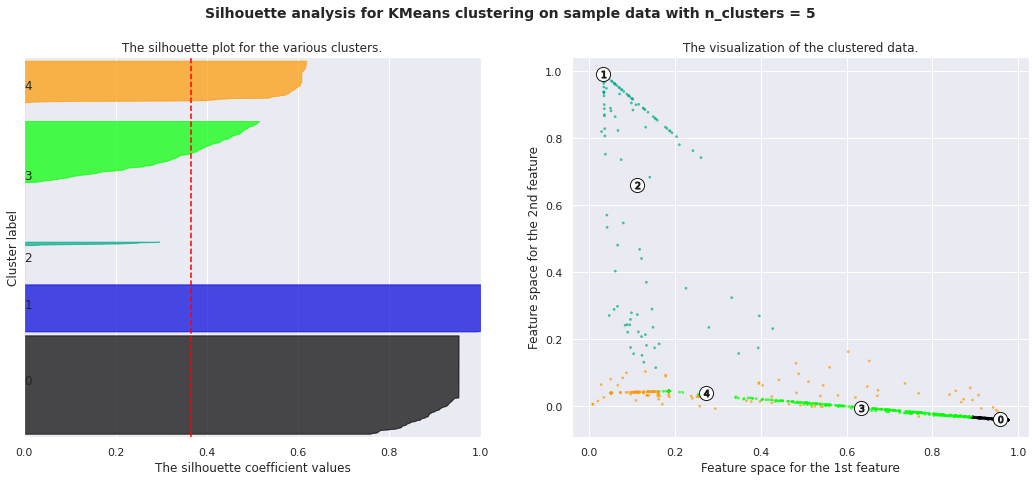

For n_clusters = 6 The average silhouette_score is : 0.2835432


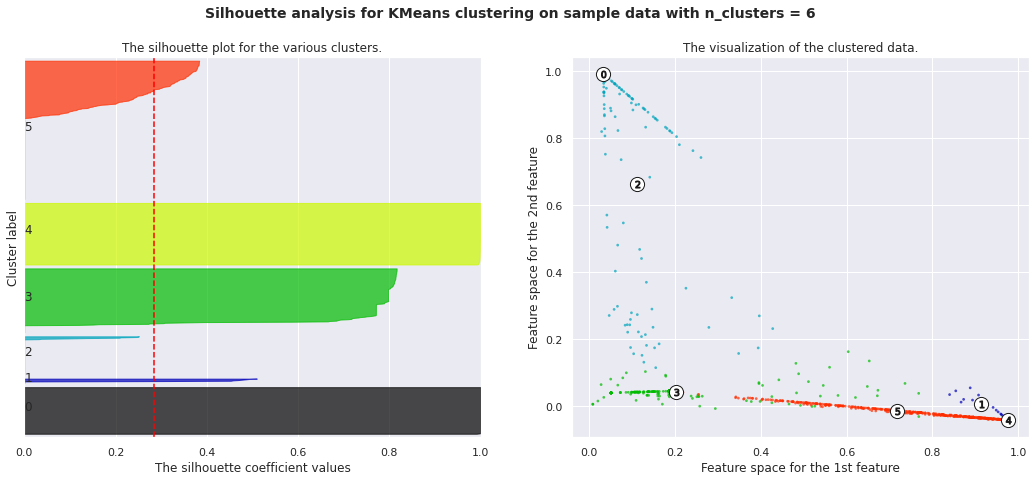

For n_clusters = 7 The average silhouette_score is : 0.31728736


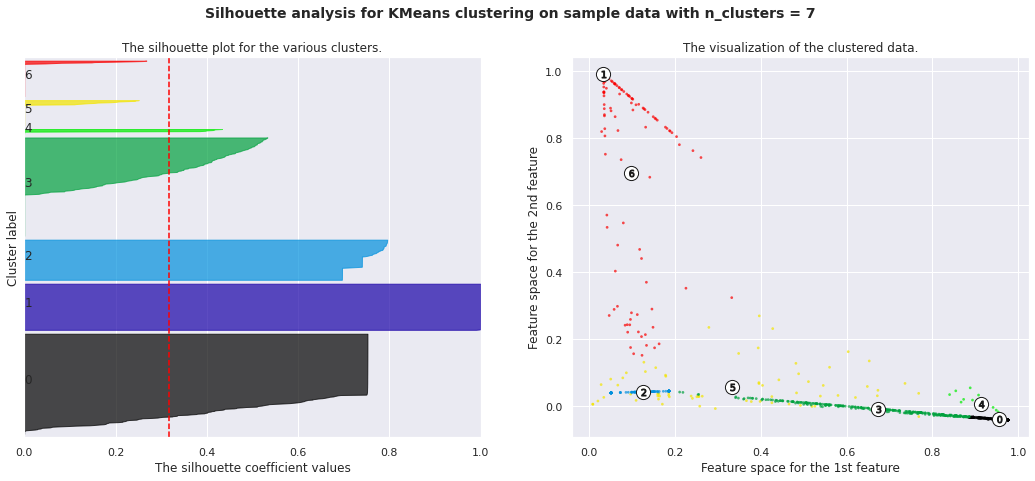

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

silhouette_with_Number_without_PCA_LDA={}

range_n_clusters = [2, 3, 4, 5, 6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(svd4) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, covariance_type='full')
    clusterer.fit(svd4)
    cluster_labels=clusterer.predict(svd4)
    cluster_labels.shape
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(svd4, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_with_Number_without_PCA_LDA[n_clusters]=silhouette_avg
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(svd4, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(0, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(svd4[:, 0], svd4[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

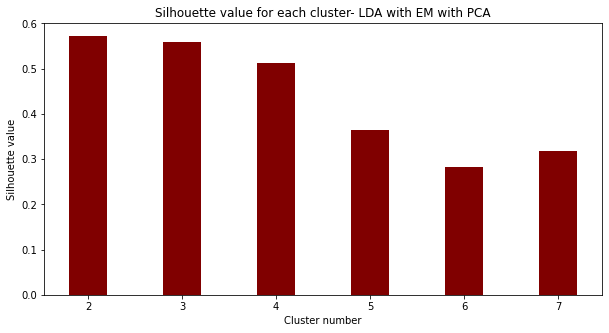

In [ ]:

 
data = {2:0.57233286,
 3:  0.5580277,
 4: 0.51278967,
 5: 0.36511812,
 6:  0.2835432,
 7: 0.31728736}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Cluster number")
plt.ylabel("Silhouette value")
plt.title("Silhouette value for each cluster- LDA with EM with PCA")
plt.show()

##Conclusion on EM

###Actual predection based on 2 clusters

###with word2vec

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np
svd3 = TruncatedSVD(n_components=2, random_state=42)
svd3=svd3.fit_transform(CountVectorizedData)
principalDf3 = pd.DataFrame(data =svd3)
principalDf3.head()


NameError: ignored

In [ ]:
gmm = GaussianMixture(n_components=2)
gmm.fit(svd3)

labels_W2V = gmm.predict(svd3)
plt.scatter(svd3[:, 0], svd3[:, 1], c=labels, cmap='viridis')

gmm.predict_proba(svd3)

TypeError: ignored

###with TF_IDF

In [ ]:
X_tf_idf = vectorizer.fit_transform(main_DF['Records'].values)

svd2 = TruncatedSVD(n_components=2, random_state=42)
svd2=svd2.fit_transform(X_tf_idf)

gmm = GaussianMixture(n_components=2)
gmm.fit(svd2)

labels_tf_idf = gmm.predict(svd2)
plt.scatter(svd2[:, 0], svd2[:, 1], c=labels, cmap='viridis')
gmm.predict_proba(svd2)


### with BOW

In [ ]:
X = cv.fit_transform(main_DF['Records'])
svd = TruncatedSVD(n_components=2, random_state=42)
svd=svd.fit_transform(X)

gmm = GaussianMixture(n_components=2)
gmm.fit(svd)

labels_BOW = gmm.predict(svd)
plt.scatter(svd[:, 0], svd[:, 1], c=labels, cmap='viridis')
gmm.predict_proba(svd)


### with LDA

In [ ]:
gmm = GaussianMixture(n_components=2)
gmm.fit(svd4)

labels_LDA = gmm.predict(svd4)
plt.scatter(svd4[:, 0], svd4[:, 1], c=labels_LDA, cmap='viridis')

gmm.predict_proba(svd4)

## Error Analysis for EM

In [ ]:
principalDf_BOW = pd.DataFrame(data =svd)
principalDf_BOW.columns =['PCA1', 'PCA2']
principalDf_BOW["Labels"]=main_DF['Labels']
principalDf_BOW

,PCA1,PCA2,Labels
0,13.086090,-1.704277,1
1,9.812937,-3.601082,1
2,11.730729,-3.921167,1
3,10.706347,-4.596703,1
4,9.755221,-2.150954,1
...,...,...,...
995,8.089559,0.775764,5
996,7.973862,0.915647,5
997,12.620203,-7.910735,5
998,10.939695,-5.965196,5


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

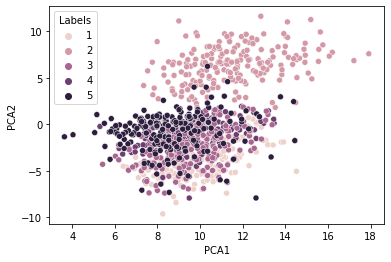

In [ ]:
import seaborn as sns
sns.scatterplot(data=principalDf_BOW, x="PCA1", y="PCA2", hue="Labels")


In [ ]:
principalDf_TF = pd.DataFrame(data =svd2)
principalDf_TF.columns =['PCA1', 'PCA2']

principalDf_TF["Labels"]=main_DF['Labels']
principalDf_TF


,PCA1,PCA2,Labels
0,0.326504,-0.115305,1
1,0.325764,-0.159421,1
2,0.361626,-0.162506,1
3,0.399347,-0.176836,1
4,0.324381,-0.106634,1
...,...,...,...
995,0.129745,0.004458,5
996,0.139900,0.010631,5
997,0.225333,-0.076562,5
998,0.216008,-0.070075,5


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

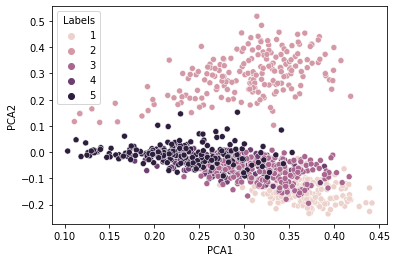

In [ ]:
sns.scatterplot(data=principalDf_TF, x="PCA1", y="PCA2", hue="Labels")


In [ ]:
principalDf_W2V = pd.DataFrame(data =svd3)
principalDf_W2V.columns =['PCA1', 'PCA2']

principalDf_W2V["Labels"]=main_DF['Labels']
principalDf_W2V


,PCA1,PCA2,Labels
0,2.021166,-2.656962,1
1,1.902520,-3.257298,1
2,1.766897,-1.968147,1
3,1.536905,-2.007922,1
4,1.381355,-1.909973,1
...,...,...,...
995,0.445501,-0.316019,5
996,0.903420,-0.634073,5
997,0.704892,-0.301262,5
998,0.923487,-0.593828,5


In [ ]:
principalDf_TF.to_csv("tf_df.csv")
principalDf_BOW.to_csv("BOW_df.csv")
principalDf_W2V.to_csv("W2V_df.csv")

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

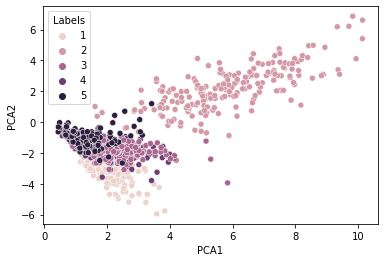

In [ ]:
sns.scatterplot(data=principalDf_W2V, x="PCA1", y="PCA2", hue="Labels")


####Get the most common words

In [ ]:
filtered_df = main_DF.loc[(main_DF['Labels'] == 1) | (main_DF['Labels'] == 3)| (main_DF['Labels'] == 4) | (main_DF['Labels'] == 5)]
filtered_df

,Unnamed: 0,Records,Labels
0,0,emma by jane austen volum i chapter i emma woo...,1
1,1,her temper had hard allow her impos ani restra...,1
2,2,father herself were left dine togeth with no p...,1
3,3,of last seven year equal foot perfect unreserv...,1
4,4,meet her in convers ration or play the evil of...,1
...,...,...,...
995,995,of switzerland i mark long winter isol i see c...,5
996,996,in aleppo i see picturesqu crowd at fair of kh...,5
997,997,i see result of persever industri of my race i...,5
998,998,mountain live lawless on taurus or caucasus yo...,5


In [ ]:
text = " ".join(cat for cat in filtered_df['Records'])

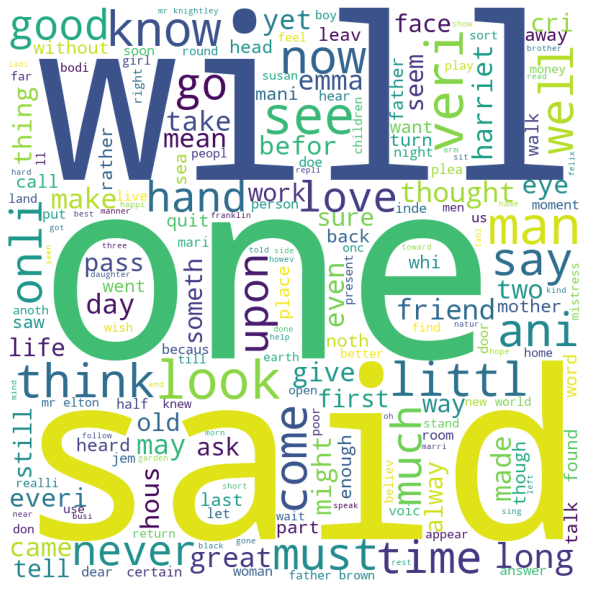

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
from collections import Counter
most_cummon_80=Counter(" ".join(filtered_df['Records']).split()).most_common(25)
most_cummon_80

[('of', 4046),
 ('i', 2955),
 ('in', 2121),
 ('he', 1834),
 ('you', 1794),
 ('was', 1632),
 ('his', 1379),
 ('with', 1274),
 ('not', 1201),
 ('for', 1178),
 ('as', 1162),
 ('her', 1100),
 ('be', 1076),
 ('but', 1070),
 ('she', 980),
 ('had', 893),
 ('at', 816),
 ('s', 810),
 ('my', 804),
 ('have', 793),
 ('him', 744),
 ('me', 736),
 ('all', 722),
 ('the', 691),
 ('or', 653)]

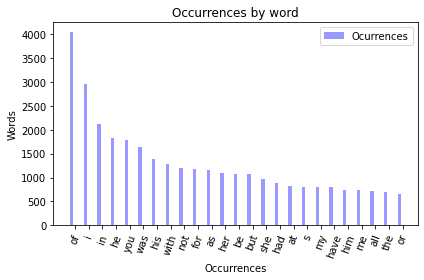

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = most_cummon_80

n_groups = len(data)

vals_films = [x[1] for x in data]
legends_films = [x[0] for x in data]

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.25

opacity = 0.4

rects1 = plt.bar(index, vals_films, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Ocurrences')


plt.xlabel('Occurrences')
plt.ylabel('Words')
plt.title('Occurrences by word')
plt.xticks(index + bar_width, legends_films)
plt.legend()
plt.xticks(rotation=70)

plt.tight_layout()
plt.show()

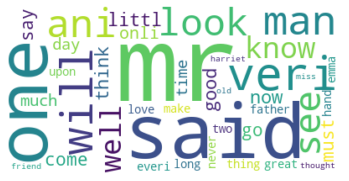

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt


text = " ".join(filtered_df['Records'])

cloud = WordCloud(collocations=False,
        background_color='white',
        max_words=40).generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

in the dataframe that contains cluster 2 ony (the Bible)

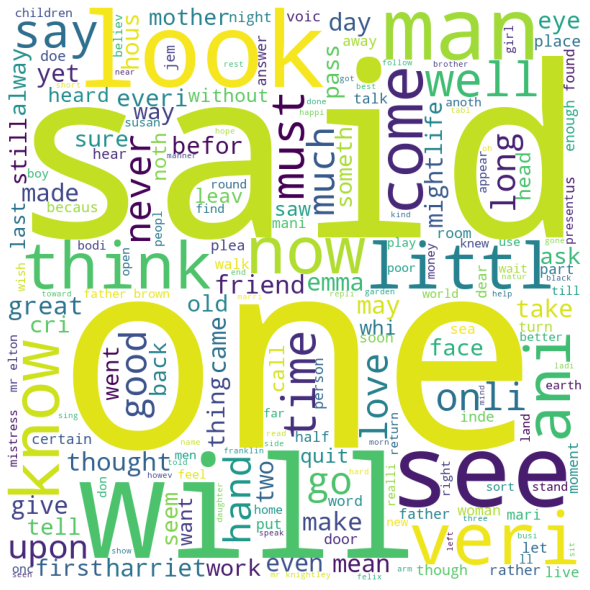

In [ ]:
filtered_df2 = main_DF.loc[main_DF['Labels']==2]

text2 = " ".join(cat for cat in filtered_df2['Records'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
most_cummon_20=Counter(" ".join(filtered_df2['Records']).split()).most_common(50)
most_cummon_20

[('of', 1291),
 ('and', 1217),
 ('he', 620),
 ('his', 600),
 ('in', 568),
 ('unto', 567),
 ('said', 466),
 ('i', 464),
 ('him', 380),
 ('my', 322),
 ('for', 308),
 ('was', 304),
 ('son', 298),
 ('me', 284),
 ('with', 280),
 ('thou', 275),
 ('thi', 264),
 ('thee', 257),
 ('be', 248),
 ('all', 242),
 ('they', 240),
 ('s', 239),
 ('god', 227),
 ('shall', 227),
 ('them', 223),
 ('not', 221),
 ('lord', 211),
 ('will', 190),
 ('which', 186),
 ('land', 183),
 ('father', 182),
 ('her', 175),
 ('came', 175),
 ('jacob', 175),
 ('she', 169),
 ('were', 159),
 ('from', 149),
 ('their', 140),
 ('had', 137),
 ('upon', 134),
 ('joseph', 132),
 ('day', 129),
 ('have', 129),
 ('abraham', 128),
 ('earth', 120),
 ('year', 120),
 ('man', 118),
 ('there', 116),
 ('behold', 116),
 ('are', 116)]

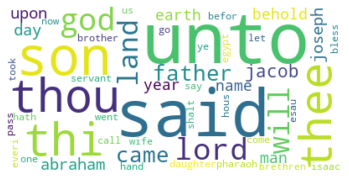

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt


text = " ".join(filtered_df2['Records'])

cloud = WordCloud(collocations=False,
        background_color='white',
        max_words=50).generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

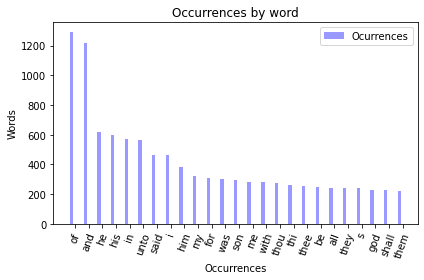

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = most_cummon_20

n_groups = len(data)

vals_films = [x[1] for x in data]
legends_films = [x[0] for x in data]

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.25

opacity = 0.4

rects1 = plt.bar(index, vals_films, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Ocurrences')


plt.xlabel('Occurrences')
plt.ylabel('Words')
plt.title('Occurrences by word')
plt.xticks(index + bar_width, legends_films)
plt.legend()
plt.xticks(rotation=70)

plt.tight_layout()
plt.show()

In [ ]:
---------------------------------------

#hierarchical model

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
data=pd.read_csv('mustafa_data.csv')
data

,Unnamed: 0,Records,Labels
0,0,emma by jane austen volum i chapter i emma woo...,austen-emma
1,1,her temper had hard allow her impos ani restra...,austen-emma
2,2,father herself were left dine togeth with no p...,austen-emma
3,3,of last seven year equal foot perfect unreserv...,austen-emma
4,4,meet her in convers ration or play the evil of...,austen-emma
...,...,...,...
995,995,of switzerland i mark long winter isol i see c...,whitman-leaves
996,996,in aleppo i see picturesqu crowd at fair of kh...,whitman-leaves
997,997,i see result of persever industri of my race i...,whitman-leaves
998,998,mountain live lawless on taurus or caucasus yo...,whitman-leaves


## with BOW

In [ ]:
#import and create object from CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [ ]:
#Apply CountVectorizer to generate matrix of words 
X_bow = cv.fit_transform(data['Records']).toarray()
y = data['Labels']
print(X_bow)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


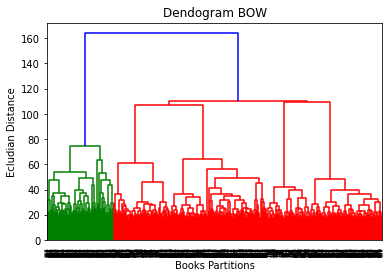

In [ ]:
plt_dendrogram = sch.dendrogram(sch.linkage(X_bow,method = 'ward'))
plt.title("Dendogram BOW")
plt.xlabel("Books Partitions")
plt.ylabel("Ecludian Distance")
hierarchical = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage = 'ward')
hierarchical_BOW = hierarchical.fit_predict(X_bow)

## with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(data['Records']).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

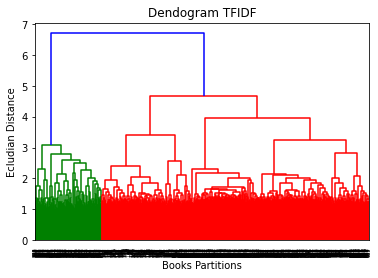

In [ ]:
plt_dendrogram = sch.dendrogram(sch.linkage(X_tfidf,method = 'ward'))
plt.title("Dendogram TFIDF")
plt.xlabel("Books Partitions")
plt.ylabel("Ecludian Distance")
hierarchical = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage = 'ward')
hierarchical_TF = hierarchical.fit_predict(X_tfidf)

## with LDA

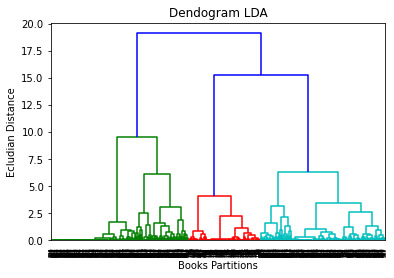

In [ ]:
plt_dendrogram = sch.dendrogram(sch.linkage(train_vecs,method = 'ward'))
plt.title("Dendogram LDA")
plt.xlabel("Books Partitions")
plt.ylabel("Ecludian Distance")
hierarchical = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage = 'ward')
hierarchical_LDA = hierarchical.fit_predict(train_vecs)

## with Word2vec

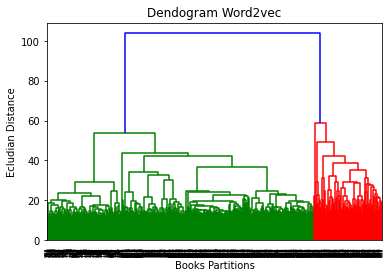

In [ ]:
plt_dendrogram = sch.dendrogram(sch.linkage(CountVectorizedData,method = 'ward'))
plt.title("Dendogram Word2vec")
plt.xlabel("Books Partitions")
plt.ylabel("Ecludian Distance")
hierarchical = AgglomerativeClustering(n_clusters = 5, affinity='euclidean', linkage = 'ward')
hierarchical_Word2vec = hierarchical.fit_predict(CountVectorizedData)

## Evaluation


In [ ]:
print("Silhouette SCore  of hierarchical clustering of BOW ",silhouette_score(X_bow,hierarchical_BOW))
print("Silhouette SCore  of hierarchical clustering of TFIDF ",silhouette_score(X_tfidf,hierarchical_TF))
print("Silhouette SCore  of hierarchical clustering of LDA ",silhouette_score(train_vecs,hierarchical_LDA))
print("Silhouette SCore  of hierarchical clustering of Word2vec ",silhouette_score(CountVectorizedData,hierarchical_Word2vec))

Silhouette SCore  of hierarchical clustering of BOW  0.027777610345893777
Silhouette SCore  of hierarchical clustering of TFIDF  0.01882492741998368
Silhouette SCore  of hierarchical clustering of LDA  0.5322777
Silhouette SCore  of hierarchical clustering of Word2vec  0.0002942472117278596
